In [1]:
%reset

In [2]:
import os ########################################
import numpy as np ###############################
import scipy.stats as stats ######################
import math ######################################
import matplotlib.pyplot as plt###################
from sklearn.metrics import mean_squared_error####

In [3]:
class reconstruct(object):
    
    def __init__(self, edge, bin_data, GMM, label):
        self.edge = edge
        self.bin_data = bin_data
        self.GMM = GMM
        self.label = label
        if len(self.bin_data.shape) > 4:
            self.x = self.bin_data.shape[0]
            self.y = self.bin_data.shape[1]
            self.z = self.bin_data.shape[2]
            self.num_of_bin = self.bin_data.shape[3]
            self.reconstructed_data = np.full((self.x, self.y, self.z, self.num_of_bin), np.inf)
        else:
            self.x = self.bin_data.shape[0]
            self.y = self.bin_data.shape[1]
            self.num_of_bin = self.bin_data.shape[2]
            self.reconstructed_data = np.full((self.x, self.y, self.num_of_bin), np.inf)
    
    def reconstruct(self, time): #bin: [index, prob, Gmm label, Num of component]
        if len(self.bin_data.shape) > 4:
            for x in range(self.x):
                for y in range(self.y):
                    for z in range(self.z):
                        self.reconstructed_data[x,y,z] = self.grid_reconstruct(self.bin_data[x,y,z], time)
        else:
            for x in range(self.x):
                for y in range(self.y):
                    self.reconstructed_data[x,y] = self.grid_reconstruct(self.bin_data[x,y], time)

    def grid_reconstruct(self, grid, time_step):
        numOfbin = len(grid)
        f = np.zeros(numOfbin)
        p = np.zeros(numOfbin)
        bin_count=0
        for bin in grid:
            if(bin[0] == -1): 
                f[bin_count] = 0
                p[bin_count] = 0
            else:
                GMM_prob = 0
                bin_index = bin[0]
                bar_prob = bin[1]
                Gmm_label = int(bin[2])
                start = int(self.label[Gmm_label])
                n_comp = int(bin[3])
                end = int(start+n_comp)
                # print('start: ', start, 'end: ',end)
                weights = self.GMM[0][start:end]
                means = self.GMM[1][start:end]
                covars = self.GMM[2][start:end]
                for n_components in range(n_comp):
                    GMM_prob += weights[n_components] * (np.exp((-((time_step-means[n_components])**2))/(2*(np.sqrt(covars[n_components])**2))) / np.sqrt(2*np.pi*(np.sqrt(covars[n_components])**2)))
                f[bin_count] = GMM_prob
                p[bin_count] = bar_prob
                start += int(n_comp)
            bin_count += 1
        postProb = f * p
        postProbSum = np.sum(postProb)
        postProb = postProb / postProbSum
        return postProb
                                       
    
    def _compute_cdf(self, pdf, edge, x):
        allcdf = np.cumsum(pdf)
        allcdf = np.hstack([0.0, allcdf])
        cdf = np.interp(x, edge, allcdf, left=0, right=0)
        return cdf
    
    # def compute_isovalue(self, iso_value):
    #     hist_edge = self.edge
        
    #     if len(self.bin_data.shape) > 4:
    #         cdf = np.zeros((self.x, self.y, self.z))
    #         for i in range(self.x):
    #             for j in range(self.y):
    #                 for k in range(self.z):
    #                     cdf[i,j,k] = self._compute_cdf(self.reconstructed_data[i,j,k], hist_edge, iso_value)
    #         cdf_1_c = 1 - cdf
    #         pCrossing = np.zeros((self.x, self.y, self.z))
    #         for l in range(self.x):
    #             for m in range(self.y):
    #                 for n in range(self.z):
    #                     if(l == self.x-1):
    #                         pCrossing[l, m, n] = pCrossing[l-1, m, n]
    #                     elif(m == self.y-1):
    #                         pCrossing[l, m, n] = pCrossing[l, m-1, n]
    #                     elif(n == self.z-1):
    #                         pCrossing[l, m, n] = pCrossing[l, m, n-1]   
    #                     else:
    #                         prob = cdf[l, m, n] * cdf[l+1, m, n] * cdf[l, m+1, n] * cdf[l, m, n+1] * cdf[l+1, m+1, n] * cdf[l+1, m, n+1] * cdf[l, m+1, n+1] * cdf[l+1, m+1, n+1]
    #                         prob2 = cdf_1_c[l, m, n] * cdf_1_c[l+1, m, n] * cdf_1_c[l, m+1, n] * cdf_1_c[l, m, n+1] * cdf_1_c[l+1, m+1, n] * cdf_1_c[l+1, m, n+1] * cdf_1_c[l, m+1, n+1] * cdf_1_c[l+1, m+1, n+1]
    #                         pCrossing[l, m, n] = 1 - prob - prob2
    #     else:    
    #         cdf = np.zeros((self.x, self.y))
    #         for i in range(self.x):
    #             for j in range(self.y):
    #                 cdf[i,j] = self._compute_cdf(self.reconstructed_data[i,j], hist_edge, iso_value)
    #         cdf_1_c = 1 - cdf
    #         pCrossing = np.zeros((self.x, self.y))
    #         for k in range(self.x):
    #             for l in range(self.y):
    #                 if(l == self.y-1):
    #                     pCrossing[k, l] = pCrossing[k, l-1]
    #                 elif(k == self.x-1):
    #                     pCrossing[k, l] = pCrossing[k-1, l]
    #                 else:
    #                     prob = cdf[k, l] * cdf[k, l+1] * cdf[k+1, l] * cdf[k+1, l+1]
    #                     prob2 = cdf_1_c[k, l] * cdf_1_c[k, l+1] * cdf_1_c[k+1, l] * cdf_1_c[k+1, l+1]
    #                     pCrossing[k, l] = 1 - prob - prob2
    #     return pCrossing              
    
    def compute_isovalue(self, reconst_data, iso_value):
        hist_edge = self.edge
        
        if len(self.bin_data.shape) > 4:
            cdf = np.zeros((self.x, self.y, self.z))
            for i in range(self.x):
                for j in range(self.y):
                    for k in range(self.z):
                        cdf[i,j,k] = self._compute_cdf(reconst_data[i,j,k], hist_edge, iso_value)
            cdf_1_c = 1 - cdf
            pCrossing = np.zeros((self.x, self.y, self.z))
            for l in range(self.x):
                for m in range(self.y):
                    for n in range(self.z):
                        if(l == self.x-1):
                            pCrossing[l, m, n] = pCrossing[l-1, m, n]
                        elif(m == self.y-1):
                            pCrossing[l, m, n] = pCrossing[l, m-1, n]
                        elif(n == self.z-1):
                            pCrossing[l, m, n] = pCrossing[l, m, n-1]   
                        else:
                            prob = cdf[l, m, n] * cdf[l+1, m, n] * cdf[l, m+1, n] * cdf[l, m, n+1] * cdf[l+1, m+1, n] * cdf[l+1, m, n+1] * cdf[l, m+1, n+1] * cdf[l+1, m+1, n+1]
                            prob2 = cdf_1_c[l, m, n] * cdf_1_c[l+1, m, n] * cdf_1_c[l, m+1, n] * cdf_1_c[l, m, n+1] * cdf_1_c[l+1, m+1, n] * cdf_1_c[l+1, m, n+1] * cdf_1_c[l, m+1, n+1] * cdf_1_c[l+1, m+1, n+1]
                            pCrossing[l, m, n] = 1 - prob - prob2
        else:    
            cdf = np.zeros((self.x, self.y))
            for i in range(self.x):
                for j in range(self.y):
                    cdf[i,j] = self._compute_cdf(reconst_data[i,j], hist_edge, iso_value)
            cdf_1_c = 1 - cdf
            pCrossing = np.zeros((self.x, self.y))
            for k in range(self.x):
                for l in range(self.y):
                    if(l == self.y-1):
                        pCrossing[k, l] = pCrossing[k, l-1]
                    elif(k == self.x-1):
                        pCrossing[k, l] = pCrossing[k-1, l]
                    else:
                        prob = cdf[k, l] * cdf[k, l+1] * cdf[k+1, l] * cdf[k+1, l+1]
                        prob2 = cdf_1_c[k, l] * cdf_1_c[k, l+1] * cdf_1_c[k+1, l] * cdf_1_c[k+1, l+1]
                        pCrossing[k, l] = 1 - prob - prob2
        return pCrossing
    
    def all_reconstruct(self, time): #bin: [index, prob, Gmm label, Num of component]
        if len(self.bin_data.shape) > 4:
            reconstructed_data = np.zeros((self.x, self.y, self.z, self.num_of_bin, time))
            for x in range(self.x):
                for y in range(self.y):
                    for z in range(self.z):
                        reconstructed_data[x,y,z] = self.all_time_reconstruct(self.bin_data[x,y,z], time)
        else:
            reconstructed_data = np.zeros((self.x, self.y, self.num_of_bin, time))
            for x in range(self.x):
                for y in range(self.y):
                    reconstructed_data[x,y] = self.all_time_reconstruct(self.bin_data[x,y], time)
        return reconstructed_data
    
    def all_time_reconstruct(self, grid, time):
        alltime = np.arange(time)
        numOfbin = len(grid)
        postProb = np.zeros((numOfbin,len(alltime)))
        bin_count=0
        SumpostProb = np.zeros(len(alltime))
        for bin in grid:
            if(bin[0] == -1):
                bin_count +=1
            else:
                GMM_prob = np.zeros(len(alltime))
                bin_index = bin[0]
                bar_prob = bin[1]
                Gmm_label = int(bin[2])
                start = int(self.label[Gmm_label])
                n_comp = int(bin[3])
                end = int(start+n_comp)
                weights = self.GMM[0][start:end]
                means = self.GMM[1][start:end]
                covars = self.GMM[2][start:end]
                for n_components in range(n_comp):
                        GMM_prob += weights[n_components] * (np.exp((-((alltime-means[n_components])**2))/(2*(np.sqrt(covars[n_components])**2))) / np.sqrt(2*np.pi*(np.sqrt(covars[n_components])**2)))
                tempPostProb = GMM_prob * bar_prob 
                SumpostProb += tempPostProb 
                postProb[bin_count] = tempPostProb
                start += int(n_comp)
                bin_count += 1
        postProb = postProb/SumpostProb
        return postProb
    

            

In [4]:
def interpolated_hist(data, numOfTimeStep, numOfensemble, interval, reconstruct_time):
    data_size = data.shape
    min_of_data = data.min()    
    max_of_data = data.max()
    x = data_size[0]
    y = data_size[1]
    z = data_size[2]
    selected_time = np.arange(0, numOfTimeStep, interval)
    # print(selected_time)
    left_timestep = np.max(selected_time[selected_time <= reconstruct_time])
    right_timestep = left_timestep + interval
    if(right_timestep > numOfTimeStep):
        right_timestep = numOfTimeStep
    # print('left: ', left_timestep, 'right: ', right_timestep)
    if(len(data_size)>3):
        inter_hist_prob = np.zeros((data_size[0],data_size[1],data_size[2],128))
        for i in range(x):
            for j in range(y):
                for k in range(z):
                    rawdataR = data[i, j, k, (right_timestep*numOfensemble):(right_timestep*numOfensemble)+numOfensemble]
                    rawdataL = data[i, j, k, (left_timestep*numOfensemble):(left_timestep*numOfensemble)+numOfensemble]
                    histR = np.histogram(rawdataR, bins=128, range=(min_of_data, max_of_data))[0]
                    histL = np.histogram(rawdataL, bins=128, range=(min_of_data, max_of_data))[0]
                    interhist = histL + (((histR-histL)/interval) * (reconstruct_time-left_timestep))
                    inter_hist_prob[i,j,k] = interhist/np.sum(interhist)
    else:
        inter_hist_prob = np.zeros((data_size[0], data_size[1], 128))
        for i in range(x):
            for j in range(y):
                rawdataR = data[i,j, (right_timestep*numOfensemble):(right_timestep*numOfensemble)+numOfensemble]
                rawdataL = data[i,j, (left_timestep*numOfensemble):(left_timestep*numOfensemble)+numOfensemble]
                histR = np.histogram(rawdataR, bins=128, range=(min_of_data, max_of_data))[0]
                histL = np.histogram(rawdataL, bins=128, range=(min_of_data, max_of_data))[0]
                interhist = histL + (((histR-histL)/interval) * (reconstruct_time-left_timestep))
                inter_hist_prob[i,j] = interhist/np.sum(interhist)
        
    return inter_hist_prob

In [5]:
def compute_error(reconstruction, raw):
    data_size = reconstruction.shape
    if (len(reconstruction.shape) >3):
        data_x = data_size[0]
        data_y = data_size[1]
        data_z = data_size[2] 
        # error = 0
        # for x in range(data_x):
        #     for y in range(data_y):
        #         for z in range(data_z):
        #             error += math.sqrt(mean_squared_error(reconstruction[x,y,z], raw[x,y,z]))
        # rmse = error / (data_x*data_y*data_z) 
        rmse = np.sum((np.sum((reconstruction - raw)**2, axis=3)/128)**(1/2))
        rmse = rmse/(data_x*data_y*data_z)
    else:
        data_x = data_size[0]
        data_y = data_size[1]

        rmse = np.sum((np.sum((reconstruction - raw)**2, axis=2)/128)**(1/2))
        rmse = rmse/(data_x*data_y)
    return rmse               

In [6]:
def compute_3Disovalue(hist_dist, isovalue):
    pcrossing = np.zeros((32,32,32))
    for i in range(32):
        for j in range(32):
            for k in range(32):
                if(j == 31):
                    pcrossing[i, j, k] = pcrossing[i, j-1, k]
                elif(i == 31):
                    pcrossing[i, j, k] = pcrossing[i-1, j, k]
                elif(k == 31):
                    pcrossing[i, j, k] = pcrossing[i, j, k-1]
                else:
                    prob = hist_dist[i, j, k].cdf(isovalue)*hist_dist[i,j+1,k].cdf(isovalue)*hist_dist[i+1,j,k].cdf(isovalue)*hist_dist[i,j,k+1].cdf(isovalue)*hist_dist[i+1,j+1,k].cdf(isovalue)*hist_dist[i+1,j,k+1].cdf(isovalue)*hist_dist[i,j+1,k+1].cdf(isovalue)*hist_dist[i+1,j+1,k+1].cdf(isovalue)
                    prob2 = (1-hist_dist[i, j,k].cdf(isovalue))*(1-hist_dist[i, j+1,k].cdf(isovalue))*(1-hist_dist[i+1, j,k].cdf(isovalue))*(1-hist_dist[i, j, k+1].cdf(isovalue))*(1-hist_dist[i+1, j+1, k].cdf(isovalue))*(1-hist_dist[i+1, j, k+1].cdf(isovalue))*(1-hist_dist[i, j+1, k+1].cdf(isovalue))*(1-hist_dist[i+1, j+1, k+1].cdf(isovalue))
                    pcrossing[i, j, k] = 1 - prob - prob2
    return pcrossing 

In [7]:
def compute_isovalue(hist_dist, isovalue):
    pcrossing = np.zeros((160,320))
    for i in range(160):
        for j in range(320):
            if(j == 159):
                pcrossing[i, j] = pcrossing[i, j-1]
            elif(i == 319):
                pcrossing[i, j] = pcrossing[i-1, j]
            else:
                prob = hist_dist[i, j].cdf(isovalue)*hist_dist[i,j+1].cdf(isovalue)*hist_dist[i+1,j].cdf(isovalue)*hist_dist[i+1,j+1].cdf(isovalue)
                prob2 = (1-hist_dist[i, j].cdf(isovalue))*(1-hist_dist[i, j+1].cdf(isovalue))*(1-hist_dist[i+1, j].cdf(isovalue))*(1-hist_dist[i+1, j+1].cdf(isovalue))
                pcrossing[i, j] = 1 - prob - prob2
    return pcrossing    

In [8]:
def compute_interp_isovalue(interp_data ,edge, isovalue):
    if len(interp_data.shape) > 3:
        x = interp_data.shape[0]
        y = interp_data.shape[1]
        z = interp_data.shape[2]
        cdf = np.zeros((x,y,z))
        for i in range(x):
            for j in range(y):
                for k in range(z):
                    allcdf = np.cumsum(interp_data[i,j,k])
                    allcdf = np.hstack([0.0, allcdf])
                    cdf[i,j,k] = np.interp(isovalue, edge, allcdf, left=0, right=0)
        cdf_1_c = 1 - cdf
        pCrossing = np.zeros((x,y,z))
        for l in range(x):
            for m in range(y):
                for n in range(z):
                    if(l == x-1):
                        pCrossing[l,m,n] = pCrossing[l-1,m,n]
                    elif(m == y-1):
                        pCrossing[l,m,n] = pCrossing[l,m-1,n]
                    elif(n == z-1):
                        pCrossing[l,m,n] = pCrossing[l,m,n-1]
                    else:
                        prob = cdf[l, m, n] * cdf[l+1, m, n] * cdf[l, m+1, n] * cdf[l, m, n+1] * cdf[l+1, m+1, n] * cdf[l+1, m, n+1] * cdf[l, m+1, n+1] * cdf[l+1, m+1, n+1]
                        prob2 = cdf_1_c[l, m, n] * cdf_1_c[l+1, m, n] * cdf_1_c[l, m+1, n] * cdf_1_c[l, m, n+1] * cdf_1_c[l+1, m+1, n] * cdf_1_c[l+1, m, n+1] * cdf_1_c[l, m+1, n+1] * cdf_1_c[l+1, m+1, n+1]
                        pCrossing[l, m, n] = 1 - prob - prob2
    else:
        x = interp_data.shape[0]
        y = interp_data.shape[1]
        cdf = np.zeros((x,y))
        for i in range(x):
            for j in range(y):
                allcdf = np.cumsum(interp_data[i,j])
                allcdf = np.hstack([0.0, allcdf])
                cdf[i,j] = np.interp(isovalue, edge, allcdf, left=0, right=0)
        cdf_1_c = 1 - cdf
        pCrossing = np.zeros((x,y))
        for k in range(x):
            for l in range(y):
                if(l == y-1):
                    pCrossing[k,l] = pCrossing[k,l-1]
                elif(k == x-1):
                    pCrossing[k,l] = pCrossing[k-1,l]
                else:
                    prob = cdf[k, l] * cdf[k, l+1] * cdf[k+1, l] * cdf[k+1, l+1]
                    prob2 = cdf_1_c[k, l] * cdf_1_c[k, l+1] * cdf_1_c[k+1, l] * cdf_1_c[k+1, l+1]
                    pCrossing[k, l] = 1 - prob - prob2
    return pCrossing            
        

In [9]:
def reconstruct_raw_bin(bin_data, x, y, z, TotalTimesteps, NumOfBins, NumOfEnsemble):
    if(z != 0):
       Reconted_data = np.zeros((TotalTimesteps, x, y, z, NumOfBins))
       for bin in bin_data:
           timestep = int(bin[0])
           x_location = int(bin[1]//(y*z))
           y_location = int((bin[1]%(y*z))//z)
           z_location = int((bin[1]%(y*z))%z)
           bin_index = int(bin[2])
           bin_prob = bin[3]/NumOfEnsemble
           Reconted_data[timestep, x_location, y_location, z_location, bin_index] = bin_prob
    else:
        Reconted_data = np.zeros((int(bin_data[:,0].max()+1), x, y, NumOfBins))
        # Reconted_data = np.zeros((TotalTimesteps, x, y, NumOfBins))
        for bin in bin_data:
            timestep = int(bin[0])
            x_location = int(bin[1]//y)
            y_location = int(bin[1]%y)
            if(y_location>=128):
                bin_index = 127
            bin_index = int(bin[2])
            if(bin_index>=128):
                bin_index = 127
            bin_prob = bin[3]/NumOfEnsemble
            Reconted_data[timestep, x_location, y_location, bin_index] = bin_prob
    return Reconted_data

In [11]:
air_data = np.load('Air_temp_160_320_ensemble60_timestep150.npy')

In [13]:
path1 = 'C:\\Users\\User\\Desktop\\master thesis\\Experiment\\Tgmm_slic\\Airta\\180_320\\test_comp1_Slice_time(150)\\'
edge_1 = np.fromfile(path1+'Air_temp_180_320_ensemble64_timestep_150.npy_comp1_edge_numOfBins_128_.bin', dtype=np.float32)
model_1 = np.fromfile(path1+'Air_temp_180_320_ensemble64_timestep_150.npy_comp1_Gmm_data_Slic0_0_x3_y82090.bin', dtype=np.float32).reshape((3,82090))
label_1 = np.fromfile(path1+'Air_temp_180_320_ensemble64_timestep_150.npy_comp1_Gmm_label.bin', dtype=np.float32)
bin_data_1 = np.fromfile(path1+'Air_temp_180_320_ensemble64_timestep_150.npy_comp1_Tgmm_Slic_0_0_bin_data_x160_y320_z128_4.bin', dtype=np.float32).reshape((160,320,128,4))
Reconted_comp1 = reconstruct(edge_1, bin_data_1, model_1, label_1)
Reconted_data_comp1 = Reconted_comp1.all_reconstruct(150)
# isocomp6 = Reconted_comp1.compute_isovalue(300)

In [20]:
path3 = 'C:\\Users\\User\\Desktop\\master thesis\\Experiment\\Tgmm_slic\\Airta\\180_320\\comp3_slice_time(150)\\'
edge_3 = np.fromfile(path3+'Air_temp_180_320_ensemble64_timestep_150.npy_comp3_edge_numOfBins_128_.bin', dtype=np.float32)
model_3 = np.fromfile(path3+'Air_temp_180_320_ensemble64_timestep_150.npy_comp3_Gmm_data_Slic0_0_x3_y189455.bin', dtype=np.float32).reshape((3,189455))
label_3 = np.fromfile(path3+'Air_temp_180_320_ensemble64_timestep_150.npy_comp3_Gmm_label.bin', dtype=np.float32)
bin_data_3 = np.fromfile(path3+'Air_temp_180_320_ensemble64_timestep_150.npy_comp3_Tgmm_Slic_0_0_bin_data_x160_y320_z128_4.bin', dtype=np.float32).reshape((160,320,128,4))
Reconted_comp3 = reconstruct(edge_3, bin_data_3, model_3, label_3)
Reconted_data_comp3 = Reconted_comp3.all_reconstruct(150)
# isocomp9 = Reconted_comp9.compute_isovalue(300)

In [21]:
path5 = 'C:\\Users\\User\\Desktop\\master thesis\\Experiment\\Tgmm_slic\\Airta\\180_320\\comp5_slice_time(150)\\'
edge_5 = np.fromfile(path5+'Air_temp_180_320_ensemble64_timestep_150.npy_comp5_edge_numOfBins_128_.bin', dtype=np.float32)
model_5 = np.fromfile(path5+'Air_temp_180_320_ensemble64_timestep_150.npy_comp5_Gmm_data_Slic0_0_x3_y295401.bin', dtype=np.float32).reshape((3,295401))
label_5 = np.fromfile(path5+'Air_temp_180_320_ensemble64_timestep_150.npy_comp5_Gmm_label.bin', dtype=np.float32)
bin_data_5 = np.fromfile(path5+'Air_temp_180_320_ensemble64_timestep_150.npy_comp5_Tgmm_Slic_0_0_bin_data_x160_y320_z128_4.bin', dtype=np.float32).reshape((160,320,128,4))
Reconted_comp5 = reconstruct(edge_5, bin_data_5, model_5, label_5)
Reconted_data_comp5 = Reconted_comp5.all_reconstruct(150)
# isocomp9 = Reconted_comp9.compute_isovalue(300)

In [63]:
path7 = 'C:\\Users\\User\\Desktop\\master thesis\\Experiment\\Tgmm_slic\\Airta\\180_320\\comp7_slice_time(150)\\'
edge_7 = np.fromfile(path7+'Air_temp_180_320_ensemble64_timestep_150.npy_comp7_edge_numOfBins_128_.bin', dtype=np.float32)
model_7 = np.fromfile(path7+'Air_temp_180_320_ensemble64_timestep_150.npy_comp7_Gmm_data_Slic0_0_x3_y390369.bin', dtype=np.float32).reshape((3,390369))
label_7 = np.fromfile(path7+'Air_temp_180_320_ensemble64_timestep_150.npy_comp7_Gmm_label.bin', dtype=np.float32)
bin_data_7 = np.fromfile(path7+'Air_temp_180_320_ensemble64_timestep_150.npy_comp7_Tgmm_Slic_0_0_bin_data_x160_y320_z128_4.bin', dtype=np.float32).reshape((160,320,128,4))
Reconted_comp7 = reconstruct(edge_7, bin_data_7, model_7, label_7)
# Reconted_data_comp7 = Reconted_comp7.all_reconstruct(150)
# isocomp9 = Reconted_comp9.compute_isovalue(300)

In [15]:
air_raw_reconted = np.fromfile('air_raw_reconted_150_160_320_128.bin', dtype='float32').reshape((150,160,320,128))

In [64]:
air_raw_iso_time49_iso300 = Reconted_comp7.compute_isovalue(air_raw_reconted[0],280)

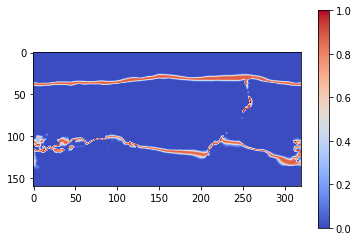

In [65]:
plt.imshow(air_raw_iso_time49_iso300, cmap='coolwarm')
plt.colorbar()

In [16]:
air_data = np.load('Air_temp_180_320_ensemble60_timestep150.npy')
inter_ta_error = np.zeros(150)
for i in range(150):
    inter_ta_error[i] = compute_error(interpolated_hist(air_data, 150, 60, 10, i), air_raw_reconted[i])
inter_ta_error.astype('float32').tofile('air_ta_interp_10_error.bin')
print('air ta interp 10 error: ', np.sum(inter_ta_error)/150)

air ta interp 10 error:  0.055608517260132495


In [16]:
comp1_error = np.zeros(150)
for i in range(150):
    comp1_error[i] = compute_error(Reconted_data_comp1[:,:,:,i], air_raw_reconted[i])
print(np.sum(comp1_error)/150)

0.049652614037933


In [18]:
comp1_error.astype('float32').tofile('Air_temp_160_320_comp1_time150_error.bin')

In [22]:
comp3_error = np.zeros(150)
comp5_error = np.zeros(150)
for i in range(150):
    comp3_error[i] = compute_error(Reconted_data_comp3[:,:,:,i], air_raw_reconted[i])
    comp5_error[i] = compute_error(Reconted_data_comp5[:,:,:,i], air_raw_reconted[i])
print('comp3 error:', np.sum(comp3_error)/150)
print('comp5 error:', np.sum(comp5_error)/150)

comp3 error: 0.04917579830223271
comp5 error: 0.04880655823549564


In [26]:
comp3_error.astype('float32').tofile('Air_temp_160_320_comp3_time150_error.bin')
comp5_error.astype('float32').tofile('Air_temp_160_320_comp5_time150_error.bin')

In [44]:
comp7_error = np.zeros(150)
for i in range(150):
    comp7_error[i] = compute_error(Reconted_data_comp7[:,:,:,i], air_raw_reconted[i])
print(np.sum(comp7_error)/150)
comp7_error.astype('float32').tofile('Air_temp_160_320_comp7_time150_error.bin')

0.04684423966187049


In [28]:
path_1_0_74 = 'C:\\Users\\User\\Desktop\\master thesis\\Experiment\\Tgmm_slic\\Airta\\180_320\\comp1_slice_time(75)\\0-74\\'
edge_1_0_74 = np.fromfile(path_1_0_74+'Air_temp_180_320_ensemble64_timestep_0-74.npy_comp1_edge_numOfBins_128_.bin', dtype=np.float32)
model_1_0_74 = np.fromfile(path_1_0_74+'Air_temp_180_320_ensemble64_timestep_0-74.npy_comp1_Gmm_data_Slic0_0_x3_y42624.bin', dtype=np.float32).reshape((3,42624))
label_1_0_74 = np.fromfile(path_1_0_74+'Air_temp_180_320_ensemble64_timestep_0-74.npy_comp1_Gmm_label.bin', dtype=np.float32)
bin_data_1_0_74 = np.fromfile(path_1_0_74+'Air_temp_180_320_ensemble64_timestep_0-74.npy_comp1_Tgmm_Slic_0_0_bin_data_x160_y320_z128_4.bin', dtype=np.float32).reshape((160,320,128,4))
Reconted_1_0_74 = reconstruct(edge_1_0_74, bin_data_1_0_74, model_1_0_74, label_1_0_74)
Reconted_data_1_0_74 = Reconted_1_0_74.all_reconstruct(75)

path_1_74_149 = 'C:\\Users\\User\\Desktop\\master thesis\\Experiment\\Tgmm_slic\\Airta\\180_320\\comp1_slice_time(75)\\75-149\\'
edge_1_74_149 = np.fromfile(path_1_74_149+'Air_temp_180_320_ensemble64_timestep_75-149.npy_comp1_edge_numOfBins_128_.bin', dtype=np.float32)
model_1_74_149 = np.fromfile(path_1_74_149+'Air_temp_180_320_ensemble64_timestep_75-149.npy_comp1_Gmm_data_Slic0_0_x3_y40766.bin', dtype=np.float32).reshape((3,40766))
label_1_74_149 = np.fromfile(path_1_74_149+'Air_temp_180_320_ensemble64_timestep_75-149.npy_comp1_Gmm_label.bin', dtype=np.float32)
bin_data_1_74_149 = np.fromfile(path_1_74_149+'Air_temp_180_320_ensemble64_timestep_75-149.npy_comp1_Tgmm_Slic_0_0_bin_data_x160_y320_z128_4.bin', dtype=np.float32).reshape((160,320,128,4))
Reconted_1_74_149= reconstruct(edge_1_74_149, bin_data_1_74_149, model_1_74_149, label_1_74_149)
Reconted_data_1_74_149 = Reconted_1_74_149.all_reconstruct(75)

In [29]:
path_3_0_74 = 'C:\\Users\\User\\Desktop\\master thesis\\Experiment\\Tgmm_slic\\Airta\\180_320\\comp3_slice_time(75)\\0-74\\'
edge_3_0_74 = np.fromfile(path_3_0_74+'Air_temp_180_320_ensemble64_timestep_0-74.npy_comp3_edge_numOfBins_128_.bin', dtype=np.float32)
model_3_0_74 = np.fromfile(path_3_0_74+'Air_temp_180_320_ensemble64_timestep_0-74.npy_comp3_Gmm_data_Slic0_0_x3_y122505.bin', dtype=np.float32).reshape((3,122505))
label_3_0_74 = np.fromfile(path_3_0_74+'Air_temp_180_320_ensemble64_timestep_0-74.npy_comp3_Gmm_label.bin', dtype=np.float32)
bin_data_3_0_74 = np.fromfile(path_3_0_74+'Air_temp_180_320_ensemble64_timestep_0-74.npy_comp3_Tgmm_Slic_0_0_bin_data_x160_y320_z128_4.bin', dtype=np.float32).reshape((160,320,128,4))
Reconted_3_0_74 = reconstruct(edge_3_0_74, bin_data_3_0_74, model_3_0_74, label_3_0_74)
Reconted_data_3_0_74 = Reconted_3_0_74.all_reconstruct(75)

path_3_74_149 = 'C:\\Users\\User\\Desktop\\master thesis\\Experiment\\Tgmm_slic\\Airta\\180_320\\comp3_slice_time(75)\\75-149\\'
edge_3_74_149 = np.fromfile(path_3_74_149+'Air_temp_180_320_ensemble64_timestep_75-149.npy_comp3_edge_numOfBins_128_.bin', dtype=np.float32)
model_3_74_149 = np.fromfile(path_3_74_149+'Air_temp_180_320_ensemble64_timestep_75-149.npy_comp3_Gmm_data_Slic0_0_x3_y117239.bin', dtype=np.float32).reshape((3,117239))
label_3_74_149 = np.fromfile(path_3_74_149+'Air_temp_180_320_ensemble64_timestep_75-149.npy_comp3_Gmm_label.bin', dtype=np.float32)
bin_data_3_74_149 = np.fromfile(path_3_74_149+'Air_temp_180_320_ensemble64_timestep_75-149.npy_comp3_Tgmm_Slic_0_0_bin_data_x160_y320_z128_4.bin', dtype=np.float32).reshape((160,320,128,4))
Reconted_3_74_149= reconstruct(edge_3_74_149, bin_data_3_74_149, model_3_74_149, label_3_74_149)
Reconted_data_3_74_149 = Reconted_3_74_149.all_reconstruct(75)

In [30]:
path_5_0_74 = 'C:\\Users\\User\\Desktop\\master thesis\\Experiment\\Tgmm_slic\\Airta\\180_320\\comp5_slice_time(75)\\0-74\\'
edge_5_0_74 = np.fromfile(path_5_0_74+'Air_temp_180_320_ensemble64_timestep_0-74.npy_comp5_edge_numOfBins_128_.bin', dtype=np.float32)
model_5_0_74 = np.fromfile(path_5_0_74+'Air_temp_180_320_ensemble64_timestep_0-74.npy_comp5_Gmm_data_Slic0_0_x3_y189358.bin', dtype=np.float32).reshape((3,189358))
label_5_0_74 = np.fromfile(path_5_0_74+'Air_temp_180_320_ensemble64_timestep_0-74.npy_comp5_Gmm_label.bin', dtype=np.float32)
bin_data_5_0_74 = np.fromfile(path_5_0_74+'Air_temp_180_320_ensemble64_timestep_0-74.npy_comp5_Tgmm_Slic_0_0_bin_data_x160_y320_z128_4.bin', dtype=np.float32).reshape((160,320,128,4))
Reconted_5_0_74 = reconstruct(edge_5_0_74, bin_data_5_0_74, model_5_0_74, label_5_0_74)
Reconted_data_5_0_74 = Reconted_5_0_74.all_reconstruct(75)

path_5_74_149 = 'C:\\Users\\User\\Desktop\\master thesis\\Experiment\\Tgmm_slic\\Airta\\180_320\\comp5_slice_time(75)\\75-149\\'
edge_5_74_149 = np.fromfile(path_5_74_149+'Air_temp_180_320_ensemble64_timestep_75-149.npy_comp5_edge_numOfBins_128_.bin', dtype=np.float32)
model_5_74_149 = np.fromfile(path_5_74_149+'Air_temp_180_320_ensemble64_timestep_75-149.npy_comp5_Gmm_data_Slic0_0_x3_y181678.bin', dtype=np.float32).reshape((3,181678))
label_5_74_149 = np.fromfile(path_5_74_149+'Air_temp_180_320_ensemble64_timestep_75-149.npy_comp5_Gmm_label.bin', dtype=np.float32)
bin_data_5_74_149 = np.fromfile(path_5_74_149+'Air_temp_180_320_ensemble64_timestep_75-149.npy_comp5_Tgmm_Slic_0_0_bin_data_x160_y320_z128_4.bin', dtype=np.float32).reshape((160,320,128,4))
Reconted_5_74_149= reconstruct(edge_5_74_149, bin_data_5_74_149, model_5_74_149, label_5_74_149)
Reconted_data_5_74_149 = Reconted_5_74_149.all_reconstruct(75)

In [70]:
path_7_0_74 = 'C:\\Users\\User\\Desktop\\master thesis\\Experiment\\Tgmm_slic\\Airta\\180_320\\comp7_slice_time(75)\\0-74\\'
edge_7_0_74 = np.fromfile(path_7_0_74+'Air_temp_180_320_ensemble64_timestep_0-74.npy_comp7_edge_numOfBins_128_.bin', dtype=np.float32)
model_7_0_74 = np.fromfile(path_7_0_74+'Air_temp_180_320_ensemble64_timestep_0-74.npy_comp7_Gmm_data_Slic0_0_x3_y251381.bin', dtype=np.float32).reshape((3,251381))
label_7_0_74 = np.fromfile(path_7_0_74+'Air_temp_180_320_ensemble64_timestep_0-74.npy_comp7_Gmm_label.bin', dtype=np.float32)
bin_data_7_0_74 = np.fromfile(path_7_0_74+'Air_temp_180_320_ensemble64_timestep_0-74.npy_comp7_Tgmm_Slic_0_0_bin_data_x160_y320_z128_4.bin', dtype=np.float32).reshape((160,320,128,4))
Reconted_7_0_74 = reconstruct(edge_7_0_74, bin_data_7_0_74, model_7_0_74, label_7_0_74)
Reconted_data_7_0_74 = Reconted_7_0_74.all_reconstruct(75)

path_7_74_149 = 'C:\\Users\\User\\Desktop\\master thesis\\Experiment\\Tgmm_slic\\Airta\\180_320\\comp7_slice_time(75)\\75-149\\'
edge_7_74_149 = np.fromfile(path_7_74_149+'Air_temp_180_320_ensemble64_timestep_75-149.npy_comp7_edge_numOfBins_128_.bin', dtype=np.float32)
model_7_74_149 = np.fromfile(path_7_74_149+'Air_temp_180_320_ensemble64_timestep_75-149.npy_comp7_Gmm_data_Slic0_0_x3_y242021.bin', dtype=np.float32).reshape((3,242021))
label_7_74_149 = np.fromfile(path_7_74_149+'Air_temp_180_320_ensemble64_timestep_75-149.npy_comp7_Gmm_label.bin', dtype=np.float32)
bin_data_7_74_149 = np.fromfile(path_7_74_149+'Air_temp_180_320_ensemble64_timestep_75-149.npy_comp7_Tgmm_Slic_0_0_bin_data_x160_y320_z128_4.bin', dtype=np.float32).reshape((160,320,128,4))
Reconted_7_74_149= reconstruct(edge_7_74_149, bin_data_7_74_149, model_7_74_149, label_7_74_149)
Reconted_data_7_74_149 = Reconted_7_74_149.all_reconstruct(75)

In [13]:
comp7_sliceTime_75_error = np.zeros(150)
for i in range(150):
    if(i<75):
        comp7_sliceTime_75_error[i] = compute_error(Reconted_data_7_0_74 [:,:,:,i], air_raw_reconted[i])
    else:
        comp7_sliceTime_75_error[i] = compute_error(Reconted_data_7_74_149[:,:,:,i-75], air_raw_reconted[i])
comp7_sliceTime_75_error.astype('float32').tofile('Air_temp_160_320_comp7_time75_error.bin')
print('comp7_sliceTime_75_error: ', np.sum(comp7_sliceTime_75_error)/150)

comp7_sliceTime_75_error:  0.02949421396601269


In [31]:
comp1_sliceTime_75_error = np.zeros(150)
comp3_sliceTime_75_error = np.zeros(150)
comp5_sliceTime_75_error = np.zeros(150)
for i in range(150):
    if(i<75):
        comp1_sliceTime_75_error[i] = compute_error(Reconted_data_1_0_74 [:,:,:,i], air_raw_reconted[i])
        comp3_sliceTime_75_error[i] = compute_error(Reconted_data_3_0_74 [:,:,:,i], air_raw_reconted[i])
        comp5_sliceTime_75_error[i] = compute_error(Reconted_data_5_0_74 [:,:,:,i], air_raw_reconted[i])
    else:
        comp1_sliceTime_75_error[i] = compute_error(Reconted_data_1_74_149[:,:,:,i-75], air_raw_reconted[i])
        comp3_sliceTime_75_error[i] = compute_error(Reconted_data_3_74_149[:,:,:,i-75], air_raw_reconted[i])
        comp5_sliceTime_75_error[i] = compute_error(Reconted_data_5_74_149[:,:,:,i-75], air_raw_reconted[i])
comp1_sliceTime_75_error.astype('float32').tofile('Air_temp_160_320_comp1_time75_error.bin')
comp3_sliceTime_75_error.astype('float32').tofile('Air_temp_160_320_comp3_time75_error.bin')
comp5_sliceTime_75_error.astype('float32').tofile('Air_temp_160_320_comp5_time75_error.bin')
print('comp1_sliceTime_75_error: ', np.sum(comp1_sliceTime_75_error)/150)
print('comp3_sliceTime_75_error: ', np.sum(comp3_sliceTime_75_error)/150)
print('comp5_sliceTime_75_error: ', np.sum(comp5_sliceTime_75_error)/150)

comp1_sliceTime_75_error:  0.04918018849355621
comp3_sliceTime_75_error:  0.04808691656280251
comp5_sliceTime_75_error:  0.03873903765711059


In [37]:
path_1_0_49 = 'C:\\Users\\User\\Desktop\\master thesis\\Experiment\\Tgmm_slic\\Airta\\180_320\\comp1_slice_time(50)\\0-49\\'
edge_1_0_49 = np.fromfile(path_1_0_49+'Air_temp_180_320_ensemble60_timestep_0-49.npy_comp1_edge_numOfBins_128_.bin', dtype=np.float32)
model_1_0_49 = np.fromfile(path_1_0_49+'Air_temp_180_320_ensemble60_timestep_0-49.npy_comp1_Gmm_data_Slic0_0_x3_y35360.bin', dtype=np.float32).reshape((3,35360))
label_1_0_49 = np.fromfile(path_1_0_49+'Air_temp_180_320_ensemble60_timestep_0-49.npy_comp1_Gmm_label.bin', dtype=np.float32)
bin_data_1_0_49 = np.fromfile(path_1_0_49+'Air_temp_180_320_ensemble60_timestep_0-49.npy_comp1_Tgmm_Slic_0_0_bin_data_x160_y320_z128_4.bin', dtype=np.float32).reshape((160,320,128,4))
Reconted_1_0_49 = reconstruct(edge_1_0_49, bin_data_1_0_49, model_1_0_49, label_1_0_49)
Reconted_data_1_0_49 = Reconted_1_0_49.all_reconstruct(50)

path_1_50_99 = 'C:\\Users\\User\\Desktop\\master thesis\\Experiment\\Tgmm_slic\\Airta\\180_320\\comp1_slice_time(50)\\50-99\\'
edge_1_50_99 = np.fromfile(path_1_50_99+'Air_temp_180_320_ensemble60_timestep_50-99.npy_comp1_edge_numOfBins_128_.bin', dtype=np.float32)
model_1_50_99 = np.fromfile(path_1_50_99+'Air_temp_180_320_ensemble60_timestep_50-99.npy_comp1_Gmm_data_Slic0_0_x3_y33552.bin', dtype=np.float32).reshape((3,33552))
label_1_50_99 = np.fromfile(path_1_50_99+'Air_temp_180_320_ensemble60_timestep_50-99.npy_comp1_Gmm_label.bin', dtype=np.float32)
bin_data_1_50_99 = np.fromfile(path_1_50_99+'Air_temp_180_320_ensemble60_timestep_50-99.npy_comp1_Tgmm_Slic_0_0_bin_data_x160_y320_z128_4.bin', dtype=np.float32).reshape((160,320,128,4))
Reconted_1_50_99 = reconstruct(edge_1_50_99, bin_data_1_50_99, model_1_50_99, label_1_50_99)
Reconted_data_1_50_99 = Reconted_1_50_99.all_reconstruct(50)

path_1_100_149 = 'C:\\Users\\User\\Desktop\\master thesis\\Experiment\\Tgmm_slic\\Airta\\180_320\\comp1_slice_time(50)\\100-149\\'
edge_1_100_149 = np.fromfile(path_1_100_149+'Air_temp_180_320_ensemble60_timestep_100-149.npy_comp1_edge_numOfBins_128_.bin', dtype=np.float32)
model_1_100_149 = np.fromfile(path_1_100_149+'Air_temp_180_320_ensemble60_timestep_100-149.npy_comp1_Gmm_data_Slic0_0_x3_y34004.bin', dtype=np.float32).reshape((3,34004))
label_1_100_149 = np.fromfile(path_1_100_149+'Air_temp_180_320_ensemble60_timestep_100-149.npy_comp1_Gmm_label.bin', dtype=np.float32)
bin_data_1_100_149 = np.fromfile(path_1_100_149+'Air_temp_180_320_ensemble60_timestep_100-149.npy_comp1_Tgmm_Slic_0_0_bin_data_x160_y320_z128_4.bin', dtype=np.float32).reshape((160,320,128,4))
Reconted_1_100_149 = reconstruct(edge_1_100_149, bin_data_1_100_149, model_1_100_149, label_1_100_149)
Reconted_data_1_100_149 = Reconted_1_100_149.all_reconstruct(50)

In [39]:
path_3_0_49 = 'C:\\Users\\User\\Desktop\\master thesis\\Experiment\\Tgmm_slic\\Airta\\180_320\\comp3_slice_time(50)\\0-49\\'
edge_3_0_49 = np.fromfile(path_3_0_49+'Air_temp_180_320_ensemble60_timestep_0-49.npy_comp3_edge_numOfBins_128_.bin', dtype=np.float32)
model_3_0_49 = np.fromfile(path_3_0_49+'Air_temp_180_320_ensemble60_timestep_0-49.npy_comp3_Gmm_data_Slic0_0_x3_y101879.bin', dtype=np.float32).reshape((3,101879))
label_3_0_49 = np.fromfile(path_3_0_49+'Air_temp_180_320_ensemble60_timestep_0-49.npy_comp3_Gmm_label.bin', dtype=np.float32)
bin_data_3_0_49 = np.fromfile(path_3_0_49+'Air_temp_180_320_ensemble60_timestep_0-49.npy_comp3_Tgmm_Slic_0_0_bin_data_x160_y320_z128_4.bin', dtype=np.float32).reshape((160,320,128,4))
Reconted_3_0_49 = reconstruct(edge_3_0_49, bin_data_3_0_49, model_3_0_49, label_3_0_49)
Reconted_data_3_0_49 = Reconted_3_0_49.all_reconstruct(50)

path_3_50_99 = 'C:\\Users\\User\\Desktop\\master thesis\\Experiment\\Tgmm_slic\\Airta\\180_320\\comp3_slice_time(50)\\50-99\\'
edge_3_50_99 = np.fromfile(path_3_50_99+'Air_temp_180_320_ensemble60_timestep_50-99.npy_comp3_edge_numOfBins_128_.bin', dtype=np.float32)
model_3_50_99 = np.fromfile(path_3_50_99+'Air_temp_180_320_ensemble60_timestep_50-99.npy_comp3_Gmm_data_Slic0_0_x3_y96813.bin', dtype=np.float32).reshape((3,96813))
label_3_50_99 = np.fromfile(path_3_50_99+'Air_temp_180_320_ensemble60_timestep_50-99.npy_comp3_Gmm_label.bin', dtype=np.float32)
bin_data_3_50_99 = np.fromfile(path_3_50_99+'Air_temp_180_320_ensemble60_timestep_50-99.npy_comp3_Tgmm_Slic_0_0_bin_data_x160_y320_z128_4.bin', dtype=np.float32).reshape((160,320,128,4))
Reconted_3_50_99 = reconstruct(edge_3_50_99, bin_data_3_50_99, model_3_50_99, label_3_50_99)
Reconted_data_3_50_99 = Reconted_3_50_99.all_reconstruct(50)

path_3_100_149 = 'C:\\Users\\User\\Desktop\\master thesis\\Experiment\\Tgmm_slic\\Airta\\180_320\\comp3_slice_time(50)\\100-149\\'
edge_3_100_149 = np.fromfile(path_3_100_149+'Air_temp_180_320_ensemble60_timestep_100-149.npy_comp3_edge_numOfBins_128_.bin', dtype=np.float32)
model_3_100_149 = np.fromfile(path_3_100_149+'Air_temp_180_320_ensemble60_timestep_100-149.npy_comp3_Gmm_data_Slic0_0_x3_y97534.bin', dtype=np.float32).reshape((3,97534))
label_3_100_149 = np.fromfile(path_3_100_149+'Air_temp_180_320_ensemble60_timestep_100-149.npy_comp3_Gmm_label.bin', dtype=np.float32)
bin_data_3_100_149 = np.fromfile(path_3_100_149+'Air_temp_180_320_ensemble60_timestep_100-149.npy_comp3_Tgmm_Slic_0_0_bin_data_x160_y320_z128_4.bin', dtype=np.float32).reshape((160,320,128,4))
Reconted_3_100_149 = reconstruct(edge_3_100_149, bin_data_3_100_149, model_3_100_149, label_3_100_149)
Reconted_data_3_100_149 = Reconted_3_100_149.all_reconstruct(50)

In [40]:
path_5_0_49 = 'C:\\Users\\User\\Desktop\\master thesis\\Experiment\\Tgmm_slic\\Airta\\180_320\\comp5_slice_time(50)\\0-49\\'
edge_5_0_49 = np.fromfile(path_5_0_49+'Air_temp_180_320_ensemble60_timestep_0-49.npy_comp5_edge_numOfBins_128_.bin', dtype=np.float32)
model_5_0_49 = np.fromfile(path_5_0_49+'Air_temp_180_320_ensemble60_timestep_0-49.npy_comp5_Gmm_data_Slic0_0_x3_y160187.bin', dtype=np.float32).reshape((3,160187))
label_5_0_49 = np.fromfile(path_5_0_49+'Air_temp_180_320_ensemble60_timestep_0-49.npy_comp5_Gmm_label.bin', dtype=np.float32)
bin_data_5_0_49 = np.fromfile(path_5_0_49+'Air_temp_180_320_ensemble60_timestep_0-49.npy_comp5_Tgmm_Slic_0_0_bin_data_x160_y320_z128_4.bin', dtype=np.float32).reshape((160,320,128,4))
Reconted_5_0_49 = reconstruct(edge_5_0_49, bin_data_5_0_49, model_5_0_49, label_5_0_49)
Reconted_data_5_0_49 = Reconted_5_0_49.all_reconstruct(50)

path_5_50_99 = 'C:\\Users\\User\\Desktop\\master thesis\\Experiment\\Tgmm_slic\\Airta\\180_320\\comp5_slice_time(50)\\50-99\\'
edge_5_50_99 = np.fromfile(path_5_50_99+'Air_temp_180_320_ensemble60_timestep_50-99.npy_comp5_edge_numOfBins_128_.bin', dtype=np.float32)
model_5_50_99 = np.fromfile(path_5_50_99+'Air_temp_180_320_ensemble60_timestep_50-99.npy_comp5_Gmm_data_Slic0_0_x3_y153337.bin', dtype=np.float32).reshape((3,153337))
label_5_50_99 = np.fromfile(path_5_50_99+'Air_temp_180_320_ensemble60_timestep_50-99.npy_comp5_Gmm_label.bin', dtype=np.float32)
bin_data_5_50_99 = np.fromfile(path_5_50_99+'Air_temp_180_320_ensemble60_timestep_50-99.npy_comp5_Tgmm_Slic_0_0_bin_data_x160_y320_z128_4.bin', dtype=np.float32).reshape((160,320,128,4))
Reconted_5_50_99 = reconstruct(edge_5_50_99, bin_data_5_50_99, model_5_50_99, label_5_50_99)
Reconted_data_5_50_99 = Reconted_5_50_99.all_reconstruct(50)

path_5_100_149 = 'C:\\Users\\User\\Desktop\\master thesis\\Experiment\\Tgmm_slic\\Airta\\180_320\\comp5_slice_time(50)\\100-149\\'
edge_5_100_149 = np.fromfile(path_5_100_149+'Air_temp_180_320_ensemble60_timestep_100-149.npy_comp5_edge_numOfBins_128_.bin', dtype=np.float32)
model_5_100_149 = np.fromfile(path_5_100_149+'Air_temp_180_320_ensemble60_timestep_100-149.npy_comp5_Gmm_data_Slic0_0_x3_y153568.bin', dtype=np.float32).reshape((3,153568))
label_5_100_149 = np.fromfile(path_5_100_149+'Air_temp_180_320_ensemble60_timestep_100-149.npy_comp5_Gmm_label.bin', dtype=np.float32)
bin_data_5_100_149 = np.fromfile(path_5_100_149+'Air_temp_180_320_ensemble60_timestep_100-149.npy_comp5_Tgmm_Slic_0_0_bin_data_x160_y320_z128_4.bin', dtype=np.float32).reshape((160,320,128,4))
Reconted_5_100_149 = reconstruct(edge_5_100_149, bin_data_5_100_149, model_5_100_149, label_5_100_149)
Reconted_data_5_100_149 = Reconted_5_100_149.all_reconstruct(50)

In [80]:
path_7_0_49 = 'C:\\Users\\User\\Desktop\\master thesis\\Experiment\\Tgmm_slic\\Airta\\180_320\\comp7_slice_time(50)\\0-49\\'
edge_7_0_49 = np.fromfile(path_7_0_49+'Air_temp_180_320_ensemble60_timestep_0-49.npy_comp7_edge_numOfBins_128_.bin', dtype=np.float32)
model_7_0_49 = np.fromfile(path_7_0_49+'Air_temp_180_320_ensemble60_timestep_0-49.npy_comp7_Gmm_data_Slic0_0_x3_y216139.bin', dtype=np.float32).reshape((3,216139))
label_7_0_49 = np.fromfile(path_7_0_49+'Air_temp_180_320_ensemble60_timestep_0-49.npy_comp7_Gmm_label.bin', dtype=np.float32)
bin_data_7_0_49 = np.fromfile(path_7_0_49+'Air_temp_180_320_ensemble60_timestep_0-49.npy_comp7_Tgmm_Slic_0_0_bin_data_x160_y320_z128_4.bin', dtype=np.float32).reshape((160,320,128,4))
Reconted_7_0_49 = reconstruct(edge_7_0_49, bin_data_7_0_49, model_7_0_49, label_7_0_49)
Reconted_data_7_0_49 = Reconted_7_0_49.all_reconstruct(50)

path_7_50_99 = 'C:\\Users\\User\\Desktop\\master thesis\\Experiment\\Tgmm_slic\\Airta\\180_320\\comp7_slice_time(50)\\50-99\\'
edge_7_50_99 = np.fromfile(path_7_50_99+'Air_temp_180_320_ensemble60_timestep_50-99.npy_comp7_edge_numOfBins_128_.bin', dtype=np.float32)
model_7_50_99 = np.fromfile(path_7_50_99+'Air_temp_180_320_ensemble60_timestep_50-99.npy_comp7_Gmm_data_Slic0_0_x3_y208193.bin', dtype=np.float32).reshape((3,208193))
label_7_50_99 = np.fromfile(path_7_50_99+'Air_temp_180_320_ensemble60_timestep_50-99.npy_comp7_Gmm_label.bin', dtype=np.float32)
bin_data_7_50_99 = np.fromfile(path_7_50_99+'Air_temp_180_320_ensemble60_timestep_50-99.npy_comp7_Tgmm_Slic_0_0_bin_data_x160_y320_z128_4.bin', dtype=np.float32).reshape((160,320,128,4))
Reconted_7_50_99 = reconstruct(edge_7_50_99, bin_data_7_50_99, model_7_50_99, label_7_50_99)
Reconted_data_7_50_99 = Reconted_7_50_99.all_reconstruct(50)

path_7_100_149 = 'C:\\Users\\User\\Desktop\\master thesis\\Experiment\\Tgmm_slic\\Airta\\180_320\\comp7_slice_time(50)\\100-149\\'
edge_7_100_149 = np.fromfile(path_7_100_149+'Air_temp_180_320_ensemble60_timestep_100-149.npy_comp7_edge_numOfBins_128_.bin', dtype=np.float32)
model_7_100_149 = np.fromfile(path_7_100_149+'Air_temp_180_320_ensemble60_timestep_100-149.npy_comp7_Gmm_data_Slic0_0_x3_y207869.bin', dtype=np.float32).reshape((3,207869))
label_7_100_149 = np.fromfile(path_7_100_149+'Air_temp_180_320_ensemble60_timestep_100-149.npy_comp7_Gmm_label.bin', dtype=np.float32)
bin_data_7_100_149 = np.fromfile(path_7_100_149+'Air_temp_180_320_ensemble60_timestep_100-149.npy_comp7_Tgmm_Slic_0_0_bin_data_x160_y320_z128_4.bin', dtype=np.float32).reshape((160,320,128,4))
Reconted_7_100_149 = reconstruct(edge_7_100_149, bin_data_7_100_149, model_7_100_149, label_7_100_149)
Reconted_data_7_100_149 = Reconted_7_100_149.all_reconstruct(50)

In [81]:
airtemp_7_50_error = np.fromfile('Air_temp_160_320_comp7_time50_error.bin',dtype='float32')

In [15]:
comp7_sliceTime_50_error = np.zeros(150)
for i in range(150):
    if(i<50):
        comp7_sliceTime_50_error[i] = compute_error(Reconted_data_7_0_49[:,:,:,i], air_raw_reconted[i])
    elif(i<100):
        comp7_sliceTime_50_error[i] = compute_error(Reconted_data_7_50_99[:,:,:,i-50], air_raw_reconted[i])
    else:
        comp7_sliceTime_50_error[i] = compute_error(Reconted_data_7_100_149[:,:,:,i-100], air_raw_reconted[i])
comp7_sliceTime_50_error.astype('float32').tofile('Air_temp_160_320_comp7_time50_error.bin')
print('comp7_sliceTime_50_error: ', np.sum(comp7_sliceTime_50_error)/150)

comp7_sliceTime_50_error:  0.027109119970298745


In [41]:
comp1_sliceTime_50_error = np.zeros(150)
comp3_sliceTime_50_error = np.zeros(150)
comp5_sliceTime_50_error = np.zeros(150)
for i in range(150):
    if(i<50):
        comp1_sliceTime_50_error[i] = compute_error(Reconted_data_1_0_49[:,:,:,i], air_raw_reconted[i])
        comp3_sliceTime_50_error[i] = compute_error(Reconted_data_3_0_49[:,:,:,i], air_raw_reconted[i])
        comp5_sliceTime_50_error[i] = compute_error(Reconted_data_5_0_49[:,:,:,i], air_raw_reconted[i])
    elif(i<100):
        comp1_sliceTime_50_error[i] = compute_error(Reconted_data_1_50_99[:,:,:,i-50], air_raw_reconted[i])
        comp3_sliceTime_50_error[i] = compute_error(Reconted_data_3_50_99[:,:,:,i-50], air_raw_reconted[i])
        comp5_sliceTime_50_error[i] = compute_error(Reconted_data_5_50_99[:,:,:,i-50], air_raw_reconted[i])
    else:
        comp1_sliceTime_50_error[i] = compute_error(Reconted_data_1_100_149[:,:,:,i-100], air_raw_reconted[i])
        comp3_sliceTime_50_error[i] = compute_error(Reconted_data_3_100_149[:,:,:,i-100], air_raw_reconted[i])
        comp5_sliceTime_50_error[i] = compute_error(Reconted_data_5_100_149[:,:,:,i-100], air_raw_reconted[i])
comp1_sliceTime_50_error.astype('float32').tofile('Air_temp_160_320_comp1_time50_error.bin')
comp3_sliceTime_50_error.astype('float32').tofile('Air_temp_160_320_comp3_time50_error.bin')
comp5_sliceTime_50_error.astype('float32').tofile('Air_temp_160_320_comp5_time50_error.bin')

print('comp1_sliceTime_50_error: ', np.sum(comp1_sliceTime_50_error)/150)
print('comp3_sliceTime_50_error: ', np.sum(comp3_sliceTime_50_error)/150)
print('comp5_sliceTime_50_error: ', np.sum(comp5_sliceTime_50_error)/150)

comp1_sliceTime_50_error:  0.04886602141001189
comp3_sliceTime_50_error:  0.04172344361712547
comp5_sliceTime_50_error:  0.029096196307672316


In [94]:
air_data = np.load('Air_temp_180_320_ensemble60_timestep150.npy')

In [118]:
inter_10 = interpolated_hist(air_data, 150, 60, 10, 37)
inter_iso = compute_interp_isovalue(inter_10, edge_7_0_49, 290)

In [119]:
airtemp_7_50_time_1_iso = Reconted_7_0_49.compute_isovalue(Reconted_data_7_0_49[:,:,:,37],290)

In [120]:
air_raw_iso = Reconted_comp7.compute_isovalue(air_raw_reconted[37],290)

In [162]:
sz_air_reconted = np.fromfile('sz_air__reconted_151_160_320_128.bin',dtype='float32').reshape((150,160,320,128))

In [165]:
sz_air_iso = Reconted_comp7.compute_isovalue(sz_air_reconted[37],290)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
fig = plt.figure(figsize = (30,5))
vmin = np.min(air_raw_iso)
vmax = np.max(air_raw_iso)
norm = matplotlib.colors.Normalize(vmin = vmin, vmax = vmax)
plt.subplot(1,4,1)
rawplot = plt.imshow(air_raw_iso,cmap='coolwarm' , norm = norm, origin='lower')
plt.title('Raw')
# p1 = plt.colorbar(rawplot)

# plt.subplot(1,4,2)
# slic4_plot = plt.imshow(sz_air_iso, cmap='coolwarm', norm = norm, origin='lower')
# plt.title('sz')
# # p2 = plt.colorbar(slic4_plot)

# plt.subplot(1,4,3)
# slic8_plot = plt.imshow(inter_iso, cmap='coolwarm', norm = norm,origin='lower')
# plt.title('inter')
# p3 = plt.colorbar(slic8_plot)

# plt.subplot(1,4,4)
# slic64_plot = plt.imshow(airtemp_7_50_time_1_iso, cmap='coolwarm', norm = norm, origin='lower')
# plt.title('SLIC comp 12')
# # p3 = plt.colorbar(slic64_plot)

plt.show()



In [48]:
nyx_raw_data = np.load('nyx_density_32cube_ensemble64_timestep200.npy')
max = nyx_raw_data.max()
min = nyx_raw_data.min()

raw_hist = np.zeros((32,32,32,128))
for i in range(32):
    for j in range(32):
        for k in range(32):
            hist = np.histogram(nyx_raw_data[i,j,k,64:128], 128, range=(min, max))
            histprob = np.array(hist[0]/64)
            raw_hist[i,j,k] = histprob

In [11]:
nyx_raw_reconted = np.fromfile('nyx_32cube_raw_reonted_200_32_32_32_128.bin', dtype='float32').reshape((200,32,32,32,128))

In [12]:
nyx_path_1_200 = 'C:\\Users\\User\\Desktop\\master thesis\\Experiment\\Tgmm_slic\\Nyx_density\\32CUBE\\comp1_Slice_time(200)\\'
edge_nyx_1_200 = np.fromfile(nyx_path_1_200+'nyx_density_32cube_ensemble64_timestep200_comp1_edge_numOfBins_128_.bin', dtype=np.float32)
model_nyx_1_200 = np.fromfile(nyx_path_1_200+'nyx_density_32cube_ensemble64_timestep200_comp1_Gmm_data_Slic0_0_x3_y58764.bin', dtype=np.float32).reshape((3,58764))
label_nyx_1_200 = np.fromfile(nyx_path_1_200+'nyx_density_32cube_ensemble64_timestep200_comp1_Gmm_label.bin', dtype=np.float32)
bin_data_nyx_1_200 = np.fromfile(nyx_path_1_200+'nyx_density_32cube_ensemble64_timestep200_comp1_Tgmm_Slic_0_0_bin_data_x32_y32_z128_4.bin', dtype=np.float32).reshape((32,32,32,128,4))
Reconted_nyx_1_200 = reconstruct(edge_nyx_1_200, bin_data_nyx_1_200, model_nyx_1_200, label_nyx_1_200)
reconted_nyx_data_1_200 = Reconted_nyx_1_200.all_reconstruct(200)
# iso_nyx_1 = Reconted_nyx_1.compute_isovalue(10e9)

In [13]:
nyx_path_3_200 = 'C:\\Users\\User\\Desktop\\master thesis\\Experiment\\Tgmm_slic\\Nyx_density\\32CUBE\\comp3_Slice_time(200)\\'
edge_nyx_3_200 = np.fromfile(nyx_path_3_200+'nyx_density_32cube_ensemble64_timestep200_comp3_edge_numOfBins_128_.bin', dtype=np.float32)
model_nyx_3_200 = np.fromfile(nyx_path_3_200+'nyx_density_32cube_ensemble64_timestep200_comp3_Gmm_data_Slic0_0_x3_y175561.bin', dtype=np.float32).reshape((3,175561))
label_nyx_3_200 = np.fromfile(nyx_path_3_200+'nyx_density_32cube_ensemble64_timestep200_comp3_Gmm_label.bin', dtype=np.float32)
bin_data_nyx_3_200 = np.fromfile(nyx_path_3_200+'nyx_density_32cube_ensemble64_timestep200_comp3_Tgmm_Slic_0_0_bin_data_x32_y32_z128_4.bin', dtype=np.float32).reshape((32,32,32,128,4))
Reconted_nyx_3_200 = reconstruct(edge_nyx_3_200, bin_data_nyx_3_200, model_nyx_3_200, label_nyx_3_200)
reconted_nyx_data_3_200 = Reconted_nyx_3_200.all_reconstruct(200)

In [14]:
nyx_path_5_200 = 'C:\\Users\\User\\Desktop\\master thesis\\Experiment\\Tgmm_slic\\Nyx_density\\32CUBE\\comp5_Slice_time(200)\\'
edge_nyx_5_200 = np.fromfile(nyx_path_5_200+'nyx_density_32cube_ensemble64_timestep200_comp5_edge_numOfBins_128_.bin', dtype=np.float32)
model_nyx_5_200 = np.fromfile(nyx_path_5_200+'nyx_density_32cube_ensemble64_timestep200_comp5_Gmm_data_Slic0_0_x3_y289488.bin', dtype=np.float32).reshape((3,289488))
label_nyx_5_200 = np.fromfile(nyx_path_5_200+'nyx_density_32cube_ensemble64_timestep200_comp5_Gmm_label.bin', dtype=np.float32)
bin_data_nyx_5_200 = np.fromfile(nyx_path_5_200+'nyx_density_32cube_ensemble64_timestep200_comp5_Tgmm_Slic_0_0_bin_data_x32_y32_z128_4.bin', dtype=np.float32).reshape((32,32,32,128,4))
Reconted_nyx_5_200 = reconstruct(edge_nyx_5_200, bin_data_nyx_5_200, model_nyx_5_200, label_nyx_5_200)
reconted_nyx_data_5_200 = Reconted_nyx_5_200.all_reconstruct(200)

In [ ]:
nyx_comp1_error = np.zeros(200)
nyx_comp3_error = np.zeros(200)
nyx_comp5_error = np.zeros(200)
for i in range(200):
    nyx_comp1_error[i] = compute_error(reconted_nyx_data_1_200[:,:,:,:,i], nyx_raw_reconted[i])
    nyx_comp3_error[i] = compute_error(reconted_nyx_data_3_200[:,:,:,:,i], nyx_raw_reconted[i])
    nyx_comp5_error[i] = compute_error(reconted_nyx_data_5_200[:,:,:,:,i], nyx_raw_reconted[i])
    
print('nyx comp1 error:', np.sum(nyx_comp1_error)/200)
print('nyx comp3 error:', np.sum(nyx_comp3_error)/200)
print('nyx comp5 error:', np.sum(nyx_comp5_error)/200)

In [68]:
nyx_comp1_error = np.zeros(200)
nyx_comp3_error = np.zeros(200)
nyx_comp5_error = np.zeros(200)
for i in range(200):
    nyx_comp1_error[i] = compute_error(reconted_nyx_data_1_200[:,:,:,:,i], nyx_raw_reconted[i])
    nyx_comp3_error[i] = compute_error(reconted_nyx_data_3_200[:,:,:,:,i], nyx_raw_reconted[i])
    nyx_comp5_error[i] = compute_error(reconted_nyx_data_5_200[:,:,:,:,i], nyx_raw_reconted[i])
    
nyx_comp1_error.astype('float32').tofile('Nyx_32cube_comp1_time200_error.bin')
nyx_comp3_error.astype('float32').tofile('Nyx_32cube_comp3_time200_error.bin')
nyx_comp5_error.astype('float32').tofile('Nyx_32cube_comp5_time200_error.bin')
print('nyx comp1 error:', np.sum(nyx_comp1_error)/200)
print('nyx comp3 error:', np.sum(nyx_comp3_error)/200)
print('nyx comp5 error:', np.sum(nyx_comp5_error)/200)


nyx comp1 error: 0.05060613467648668
nyx comp3 error: 0.031217406924893075
nyx comp5 error: 0.030116027192903082


In [63]:
nyx_path_1_0_99 = 'C:\\Users\\User\\Desktop\\master thesis\\Experiment\\Tgmm_slic\\Nyx_density\\32CUBE\\comp1_Slice_time(100)\\0-99\\'
edge_nyx_1_0_99 = np.fromfile(nyx_path_1_0_99+'nyx_density_32cube_ensemble64_timestep_0-99.npy_comp1_edge_numOfBins_128_.bin', dtype=np.float32)
model_nyx_1_0_99 = np.fromfile(nyx_path_1_0_99+'nyx_density_32cube_ensemble64_timestep_0-99.npy_comp1_Gmm_data_Slic0_0_x3_y41792.bin', dtype=np.float32).reshape((3,41792))
label_nyx_1_0_99 = np.fromfile(nyx_path_1_0_99+'nyx_density_32cube_ensemble64_timestep_0-99.npy_comp1_Gmm_label.bin', dtype=np.float32)
bin_data_nyx_1_0_99 = np.fromfile(nyx_path_1_0_99+'nyx_density_32cube_ensemble64_timestep_0-99.npy_comp1_Tgmm_Slic_0_0_bin_data_x32_y32_z128_4.bin', dtype=np.float32).reshape((32,32,32,128,4))
Reconted_nyx_1_0_99 = reconstruct(edge_nyx_1_0_99, bin_data_nyx_1_0_99, model_nyx_1_0_99, label_nyx_1_0_99)
reconted_nyx_data_1_0_99 = Reconted_nyx_1_0_99.all_reconstruct(100)

nyx_path_1_100_199 = 'C:\\Users\\User\\Desktop\\master thesis\\Experiment\\Tgmm_slic\\Nyx_density\\32CUBE\\comp1_Slice_time(100)\\100-199\\'
edge_nyx_1_100_199 = np.fromfile(nyx_path_1_100_199+'nyx_density_32cube_ensemble64_timestep_100-199.npy_comp1_edge_numOfBins_128_.bin', dtype=np.float32)
model_nyx_1_100_199 = np.fromfile(nyx_path_1_100_199+'nyx_density_32cube_ensemble64_timestep_100-199.npy_comp1_Gmm_data_Slic0_0_x3_y22456.bin', dtype=np.float32).reshape((3,22456))
label_nyx_1_100_199 = np.fromfile(nyx_path_1_100_199+'nyx_density_32cube_ensemble64_timestep_100-199.npy_comp1_Gmm_label.bin', dtype=np.float32)
bin_data_nyx_1_100_199 = np.fromfile(nyx_path_1_100_199+'nyx_density_32cube_ensemble64_timestep_100-199.npy_comp1_Tgmm_Slic_0_0_bin_data_x32_y32_z128_4.bin', dtype=np.float32).reshape((32,32,32,128,4))
Reconted_nyx_1_100_199 = reconstruct(edge_nyx_1_100_199, bin_data_nyx_1_100_199, model_nyx_1_100_199, label_nyx_1_100_199)
reconted_nyx_data_1_100_199 = Reconted_nyx_1_100_199.all_reconstruct(100)

In [64]:
nyx_path_3_0_99 = 'C:\\Users\\User\\Desktop\\master thesis\\Experiment\\Tgmm_slic\\Nyx_density\\32CUBE\\comp3_Slice_time(100)\\0-99\\'
edge_nyx_3_0_99 = np.fromfile(nyx_path_3_0_99+'nyx_density_32cube_ensemble64_timestep_0-99.npy_comp3_edge_numOfBins_128_.bin', dtype=np.float32)
model_nyx_3_0_99 = np.fromfile(nyx_path_3_0_99+'nyx_density_32cube_ensemble64_timestep_0-99.npy_comp3_Gmm_data_Slic0_0_x3_y124578.bin', dtype=np.float32).reshape((3,124578))
label_nyx_3_0_99 = np.fromfile(nyx_path_3_0_99+'nyx_density_32cube_ensemble64_timestep_0-99.npy_comp3_Gmm_label.bin', dtype=np.float32)
bin_data_nyx_3_0_99 = np.fromfile(nyx_path_3_0_99+'nyx_density_32cube_ensemble64_timestep_0-99.npy_comp3_Tgmm_Slic_0_0_bin_data_x32_y32_z128_4.bin', dtype=np.float32).reshape((32,32,32,128,4))
Reconted_nyx_3_0_99 = reconstruct(edge_nyx_3_0_99, bin_data_nyx_3_0_99, model_nyx_3_0_99, label_nyx_3_0_99)
reconted_nyx_data_3_0_99 = Reconted_nyx_3_0_99.all_reconstruct(100)

nyx_path_3_100_199 = 'C:\\Users\\User\\Desktop\\master thesis\\Experiment\\Tgmm_slic\\Nyx_density\\32CUBE\\comp3_Slice_time(100)\\100-199\\'
edge_nyx_3_100_199 = np.fromfile(nyx_path_3_100_199+'nyx_density_32cube_ensemble64_timestep_100-199.npy_comp3_edge_numOfBins_128_.bin', dtype=np.float32)
model_nyx_3_100_199 = np.fromfile(nyx_path_3_100_199+'nyx_density_32cube_ensemble64_timestep_100-199.npy_comp3_Gmm_data_Slic0_0_x3_y67271.bin', dtype=np.float32).reshape((3,67271))
label_nyx_3_100_199 = np.fromfile(nyx_path_3_100_199+'nyx_density_32cube_ensemble64_timestep_100-199.npy_comp3_Gmm_label.bin', dtype=np.float32)
bin_data_nyx_3_100_199 = np.fromfile(nyx_path_3_100_199+'nyx_density_32cube_ensemble64_timestep_100-199.npy_comp3_Tgmm_Slic_0_0_bin_data_x32_y32_z128_4.bin', dtype=np.float32).reshape((32,32,32,128,4))
Reconted_nyx_3_100_199 = reconstruct(edge_nyx_3_100_199, bin_data_nyx_3_100_199, model_nyx_3_100_199, label_nyx_3_100_199)
reconted_nyx_data_3_100_199 = Reconted_nyx_3_100_199.all_reconstruct(100)

In [65]:
nyx_path_5_0_99 = 'C:\\Users\\User\\Desktop\\master thesis\\Experiment\\Tgmm_slic\\Nyx_density\\32CUBE\\comp5_Slice_time(100)\\0-99\\'
edge_nyx_5_0_99 = np.fromfile(nyx_path_5_0_99+'nyx_density_32cube_ensemble64_timestep_0-99.npy_comp5_edge_numOfBins_128_.bin', dtype=np.float32)
model_nyx_5_0_99 = np.fromfile(nyx_path_5_0_99+'nyx_density_32cube_ensemble64_timestep_0-99.npy_comp5_Gmm_data_Slic0_0_x3_y204393.bin', dtype=np.float32).reshape((3,204393))
label_nyx_5_0_99 = np.fromfile(nyx_path_5_0_99+'nyx_density_32cube_ensemble64_timestep_0-99.npy_comp5_Gmm_label.bin', dtype=np.float32)
bin_data_nyx_5_0_99 = np.fromfile(nyx_path_5_0_99+'nyx_density_32cube_ensemble64_timestep_0-99.npy_comp5_Tgmm_Slic_0_0_bin_data_x32_y32_z128_4.bin', dtype=np.float32).reshape((32,32,32,128,4))
Reconted_nyx_5_0_99 = reconstruct(edge_nyx_5_0_99, bin_data_nyx_5_0_99, model_nyx_5_0_99, label_nyx_5_0_99)
reconted_nyx_data_5_0_99 = Reconted_nyx_5_0_99.all_reconstruct(100)

nyx_path_5_100_199 = 'C:\\Users\\User\\Desktop\\master thesis\\Experiment\\Tgmm_slic\\Nyx_density\\32CUBE\\comp5_Slice_time(100)\\100-199\\'
edge_nyx_5_100_199 = np.fromfile(nyx_path_5_100_199+'nyx_density_32cube_ensemble64_timestep_100-199.npy_comp5_edge_numOfBins_128_.bin', dtype=np.float32)
model_nyx_5_100_199 = np.fromfile(nyx_path_5_100_199+'nyx_density_32cube_ensemble64_timestep_100-199.npy_comp5_Gmm_data_Slic0_0_x3_y111714.bin', dtype=np.float32).reshape((3,111714))
label_nyx_5_100_199 = np.fromfile(nyx_path_5_100_199+'nyx_density_32cube_ensemble64_timestep_100-199.npy_comp5_Gmm_label.bin', dtype=np.float32)
bin_data_nyx_5_100_199 = np.fromfile(nyx_path_5_100_199+'nyx_density_32cube_ensemble64_timestep_100-199.npy_comp5_Tgmm_Slic_0_0_bin_data_x32_y32_z128_4.bin', dtype=np.float32).reshape((32,32,32,128,4))
Reconted_nyx_5_100_199 = reconstruct(edge_nyx_5_100_199, bin_data_nyx_5_100_199, model_nyx_5_100_199, label_nyx_5_100_199)
reconted_nyx_data_5_100_199 = Reconted_nyx_5_100_199.all_reconstruct(100)

In [70]:
nyx_comp1_sliceTime_100_error = np.zeros(200)
nyx_comp3_sliceTime_100_error = np.zeros(200)
nyx_comp5_sliceTime_100_error = np.zeros(200)
for i in range(200):
    if(i<100):
        nyx_comp1_sliceTime_100_error[i] = compute_error(reconted_nyx_data_1_0_99 [:,:,:,:,i], nyx_raw_reconted[i])
        nyx_comp3_sliceTime_100_error[i] = compute_error(reconted_nyx_data_3_0_99 [:,:,:,:,i], nyx_raw_reconted[i])
        nyx_comp5_sliceTime_100_error[i] = compute_error(reconted_nyx_data_5_0_99 [:,:,:,:,i], nyx_raw_reconted[i])
    else:
        nyx_comp1_sliceTime_100_error[i] = compute_error(reconted_nyx_data_1_100_199 [:,:,:,:,i-100], nyx_raw_reconted[i])
        nyx_comp3_sliceTime_100_error[i] = compute_error(reconted_nyx_data_3_100_199 [:,:,:,:,i-100], nyx_raw_reconted[i])
        nyx_comp5_sliceTime_100_error[i] = compute_error(reconted_nyx_data_5_100_199 [:,:,:,:,i-100], nyx_raw_reconted[i])
nyx_comp1_sliceTime_100_error.astype('float32').tofile('Nyx_32cube_comp1_time100_error.bin')
nyx_comp3_sliceTime_100_error.astype('float32').tofile('Nyx_32cube_comp3_time100_error.bin')
nyx_comp5_sliceTime_100_error.astype('float32').tofile('Nyx_32cube_comp5_time100_error.bin')
print('nyx_comp1_sliceTime_100_error: ', np.sum(nyx_comp1_sliceTime_100_error)/200)
print('nyx_comp3_sliceTime_100_error: ', np.sum(nyx_comp3_sliceTime_100_error)/200)
print('nyx_comp5_sliceTime_100_error: ', np.sum(nyx_comp5_sliceTime_100_error)/200)

nyx_comp1_sliceTime_100_error:  0.04049667377742144
nyx_comp3_sliceTime_100_error:  0.030099749769016103
nyx_comp5_sliceTime_100_error:  0.0293317680984235


In [72]:
nyx_path_1_0_49 = 'C:\\Users\\User\\Desktop\\master thesis\\Experiment\\Tgmm_slic\\Nyx_density\\32CUBE\\comp1_Slice_time(50)\\0-49\\'
edge_nyx_1_0_49 = np.fromfile(nyx_path_1_0_49+'nyx_density_32cube_ensemble64_timestep_0-49.npy_comp1_edge_numOfBins_128_.bin', dtype=np.float32)
model_nyx_1_0_49 = np.fromfile(nyx_path_1_0_49+'nyx_density_32cube_ensemble64_timestep_0-49.npy_comp1_Gmm_data_Slic0_0_x3_y33604.bin', dtype=np.float32).reshape((3,33604))
label_nyx_1_0_49 = np.fromfile(nyx_path_1_0_49+'nyx_density_32cube_ensemble64_timestep_0-49.npy_comp1_Gmm_label.bin', dtype=np.float32)
bin_data_nyx_1_0_49 = np.fromfile(nyx_path_1_0_49+'nyx_density_32cube_ensemble64_timestep_0-49.npy_comp1_Tgmm_Slic_0_0_bin_data_x32_y32_z128_4.bin', dtype=np.float32).reshape((32,32,32,128,4))
Reconted_nyx_1_0_49 = reconstruct(edge_nyx_1_0_49, bin_data_nyx_1_0_49, model_nyx_1_0_49, label_nyx_1_0_49)
reconted_nyx_data_1_0_49 = Reconted_nyx_1_0_49.all_reconstruct(50)

nyx_path_1_50_99 = 'C:\\Users\\User\\Desktop\\master thesis\\Experiment\\Tgmm_slic\\Nyx_density\\32CUBE\\comp1_Slice_time(50)\\50-99\\'
edge_nyx_1_50_99 = np.fromfile(nyx_path_1_50_99+'nyx_density_32cube_ensemble64_timestep_50-99.npy_comp1_edge_numOfBins_128_.bin', dtype=np.float32)
model_nyx_1_50_99 = np.fromfile(nyx_path_1_50_99+'nyx_density_32cube_ensemble64_timestep_50-99.npy_comp1_Gmm_data_Slic0_0_x3_y20111.bin', dtype=np.float32).reshape((3,20111))
label_nyx_1_50_99 = np.fromfile(nyx_path_1_50_99+'nyx_density_32cube_ensemble64_timestep_50-99.npy_comp1_Gmm_label.bin', dtype=np.float32)
bin_data_nyx_1_50_99 = np.fromfile(nyx_path_1_50_99+'nyx_density_32cube_ensemble64_timestep_50-99.npy_comp1_Tgmm_Slic_0_0_bin_data_x32_y32_z128_4.bin', dtype=np.float32).reshape((32,32,32,128,4))
Reconted_nyx_1_50_99 = reconstruct(edge_nyx_1_50_99, bin_data_nyx_1_50_99, model_nyx_1_50_99, label_nyx_1_50_99)
reconted_nyx_data_1_50_99 = Reconted_nyx_1_50_99.all_reconstruct(50)

nyx_path_1_100_149 = 'C:\\Users\\User\\Desktop\\master thesis\\Experiment\\Tgmm_slic\\Nyx_density\\32CUBE\\comp1_Slice_time(50)\\100-149\\'
edge_nyx_1_100_149 = np.fromfile(nyx_path_1_100_149+'nyx_density_32cube_ensemble64_timestep_100-149.npy_comp1_edge_numOfBins_128_.bin', dtype=np.float32)
model_nyx_1_100_149 = np.fromfile(nyx_path_1_100_149+'nyx_density_32cube_ensemble64_timestep_100-149.npy_comp1_Gmm_data_Slic0_0_x3_y13954.bin', dtype=np.float32).reshape((3,13954))
label_nyx_1_100_149 = np.fromfile(nyx_path_1_100_149+'nyx_density_32cube_ensemble64_timestep_100-149.npy_comp1_Gmm_label.bin', dtype=np.float32)
bin_data_nyx_1_100_149 = np.fromfile(nyx_path_1_100_149+'nyx_density_32cube_ensemble64_timestep_100-149.npy_comp1_Tgmm_Slic_0_0_bin_data_x32_y32_z128_4.bin', dtype=np.float32).reshape((32,32,32,128,4))
Reconted_nyx_1_100_149 = reconstruct(edge_nyx_1_100_149, bin_data_nyx_1_100_149, model_nyx_1_100_149, label_nyx_1_100_149)
reconted_nyx_data_1_100_149 = Reconted_nyx_1_100_149.all_reconstruct(50)

nyx_path_1_150_199 = 'C:\\Users\\User\\Desktop\\master thesis\\Experiment\\Tgmm_slic\\Nyx_density\\32CUBE\\comp1_Slice_time(50)\\150-199\\'
edge_nyx_1_150_199 = np.fromfile(nyx_path_1_150_199+'nyx_density_32cube_ensemble64_timestep_150-199.npy_comp1_edge_numOfBins_128_.bin', dtype=np.float32)
model_nyx_1_150_199 = np.fromfile(nyx_path_1_150_199+'nyx_density_32cube_ensemble64_timestep_150-199.npy_comp1_Gmm_data_Slic0_0_x3_y12933.bin', dtype=np.float32).reshape((3,12933))
label_nyx_1_150_199 = np.fromfile(nyx_path_1_150_199+'nyx_density_32cube_ensemble64_timestep_150-199.npy_comp1_Gmm_label.bin', dtype=np.float32)
bin_data_nyx_1_150_199 = np.fromfile(nyx_path_1_150_199+'nyx_density_32cube_ensemble64_timestep_150-199.npy_comp1_Tgmm_Slic_0_0_bin_data_x32_y32_z128_4.bin', dtype=np.float32).reshape((32,32,32,128,4))
Reconted_nyx_1_150_199 = reconstruct(edge_nyx_1_150_199, bin_data_nyx_1_150_199, model_nyx_1_150_199, label_nyx_1_150_199)
reconted_nyx_data_1_150_199 = Reconted_nyx_1_150_199.all_reconstruct(50)

In [73]:
nyx_path_3_0_49 = 'C:\\Users\\User\\Desktop\\master thesis\\Experiment\\Tgmm_slic\\Nyx_density\\32CUBE\\comp3_Slice_time(50)\\0-49\\'
edge_nyx_3_0_49 = np.fromfile(nyx_path_3_0_49+'nyx_density_32cube_ensemble64_timestep_0-49.npy_comp3_edge_numOfBins_128_.bin', dtype=np.float32)
model_nyx_3_0_49 = np.fromfile(nyx_path_3_0_49+'nyx_density_32cube_ensemble64_timestep_0-49.npy_comp3_Gmm_data_Slic0_0_x3_y100023.bin', dtype=np.float32).reshape((3,100023))
label_nyx_3_0_49 = np.fromfile(nyx_path_3_0_49+'nyx_density_32cube_ensemble64_timestep_0-49.npy_comp3_Gmm_label.bin', dtype=np.float32)
bin_data_nyx_3_0_49 = np.fromfile(nyx_path_3_0_49+'nyx_density_32cube_ensemble64_timestep_0-49.npy_comp3_Tgmm_Slic_0_0_bin_data_x32_y32_z128_4.bin', dtype=np.float32).reshape((32,32,32,128,4))
Reconted_nyx_3_0_49 = reconstruct(edge_nyx_3_0_49, bin_data_nyx_3_0_49, model_nyx_3_0_49, label_nyx_3_0_49)
reconted_nyx_data_3_0_49 = Reconted_nyx_3_0_49.all_reconstruct(50)

nyx_path_3_50_99 = 'C:\\Users\\User\\Desktop\\master thesis\\Experiment\\Tgmm_slic\\Nyx_density\\32CUBE\\comp3_Slice_time(50)\\50-99\\'
edge_nyx_3_50_99 = np.fromfile(nyx_path_3_50_99+'nyx_density_32cube_ensemble64_timestep_50-99.npy_comp3_edge_numOfBins_128_.bin', dtype=np.float32)
model_nyx_3_50_99 = np.fromfile(nyx_path_3_50_99+'nyx_density_32cube_ensemble64_timestep_50-99.npy_comp3_Gmm_data_Slic0_0_x3_y60115.bin', dtype=np.float32).reshape((3,60115))
label_nyx_3_50_99 = np.fromfile(nyx_path_3_50_99+'nyx_density_32cube_ensemble64_timestep_50-99.npy_comp3_Gmm_label.bin', dtype=np.float32)
bin_data_nyx_3_50_99 = np.fromfile(nyx_path_3_50_99+'nyx_density_32cube_ensemble64_timestep_50-99.npy_comp3_Tgmm_Slic_0_0_bin_data_x32_y32_z128_4.bin', dtype=np.float32).reshape((32,32,32,128,4))
Reconted_nyx_3_50_99 = reconstruct(edge_nyx_3_50_99, bin_data_nyx_3_50_99, model_nyx_3_50_99, label_nyx_3_50_99)
reconted_nyx_data_3_50_99 = Reconted_nyx_3_50_99.all_reconstruct(50)

nyx_path_3_100_149 = 'C:\\Users\\User\\Desktop\\master thesis\\Experiment\\Tgmm_slic\\Nyx_density\\32CUBE\\comp3_Slice_time(50)\\100-149\\'
edge_nyx_3_100_149 = np.fromfile(nyx_path_3_100_149+'nyx_density_32cube_ensemble64_timestep_100-149.npy_comp3_edge_numOfBins_128_.bin', dtype=np.float32)
model_nyx_3_100_149 = np.fromfile(nyx_path_3_100_149+'nyx_density_32cube_ensemble64_timestep_100-149.npy_comp3_Gmm_data_Slic0_0_x3_y41753.bin', dtype=np.float32).reshape((3,41753))
label_nyx_3_100_149 = np.fromfile(nyx_path_3_100_149+'nyx_density_32cube_ensemble64_timestep_100-149.npy_comp3_Gmm_label.bin', dtype=np.float32)
bin_data_nyx_3_100_149 = np.fromfile(nyx_path_3_100_149+'nyx_density_32cube_ensemble64_timestep_100-149.npy_comp3_Tgmm_Slic_0_0_bin_data_x32_y32_z128_4.bin', dtype=np.float32).reshape((32,32,32,128,4))
Reconted_nyx_3_100_149 = reconstruct(edge_nyx_3_100_149, bin_data_nyx_3_100_149, model_nyx_3_100_149, label_nyx_3_100_149)
reconted_nyx_data_3_100_149 = Reconted_nyx_3_100_149.all_reconstruct(50)

nyx_path_3_150_199 = 'C:\\Users\\User\\Desktop\\master thesis\\Experiment\\Tgmm_slic\\Nyx_density\\32CUBE\\comp3_Slice_time(50)\\150-199\\'
edge_nyx_3_150_199 = np.fromfile(nyx_path_3_150_199+'nyx_density_32cube_ensemble64_timestep_150-199.npy_comp3_edge_numOfBins_128_.bin', dtype=np.float32)
model_nyx_3_150_199 = np.fromfile(nyx_path_3_150_199+'nyx_density_32cube_ensemble64_timestep_150-199.npy_comp3_Gmm_data_Slic0_0_x3_y38721.bin', dtype=np.float32).reshape((3,38721))
label_nyx_3_150_199 = np.fromfile(nyx_path_3_150_199+'nyx_density_32cube_ensemble64_timestep_150-199.npy_comp3_Gmm_label.bin', dtype=np.float32)
bin_data_nyx_3_150_199 = np.fromfile(nyx_path_3_150_199+'nyx_density_32cube_ensemble64_timestep_150-199.npy_comp3_Tgmm_Slic_0_0_bin_data_x32_y32_z128_4.bin', dtype=np.float32).reshape((32,32,32,128,4))
Reconted_nyx_3_150_199 = reconstruct(edge_nyx_3_150_199, bin_data_nyx_3_150_199, model_nyx_3_150_199, label_nyx_3_150_199)
reconted_nyx_data_3_150_199 = Reconted_nyx_3_150_199.all_reconstruct(50)

In [187]:
nyx_path_5_0_49 = 'C:\\Users\\User\\Desktop\\master thesis\\Experiment\\Tgmm_slic\\Nyx_density\\32CUBE\\comp5_Slice_time(50)\\0-49\\'
edge_nyx_5_0_49 = np.fromfile(nyx_path_5_0_49+'nyx_density_32cube_ensemble64_timestep_0-49.npy_comp5_edge_numOfBins_128_.bin', dtype=np.float32)
model_nyx_5_0_49 = np.fromfile(nyx_path_5_0_49+'nyx_density_32cube_ensemble64_timestep_0-49.npy_comp5_Gmm_data_Slic0_0_x3_y163599.bin', dtype=np.float32).reshape((3,163599))
label_nyx_5_0_49 = np.fromfile(nyx_path_5_0_49+'nyx_density_32cube_ensemble64_timestep_0-49.npy_comp5_Gmm_label.bin', dtype=np.float32)
bin_data_nyx_5_0_49 = np.fromfile(nyx_path_5_0_49+'nyx_density_32cube_ensemble64_timestep_0-49.npy_comp5_Tgmm_Slic_0_0_bin_data_x32_y32_z128_4.bin', dtype=np.float32).reshape((32,32,32,128,4))
Reconted_nyx_5_0_49 = reconstruct(edge_nyx_5_0_49, bin_data_nyx_5_0_49, model_nyx_5_0_49, label_nyx_5_0_49)
reconted_nyx_data_5_0_49 = Reconted_nyx_5_0_49.all_reconstruct(50)

nyx_path_5_50_99 = 'C:\\Users\\User\\Desktop\\master thesis\\Experiment\\Tgmm_slic\\Nyx_density\\32CUBE\\comp5_Slice_time(50)\\50-99\\'
edge_nyx_5_50_99 = np.fromfile(nyx_path_5_50_99+'nyx_density_32cube_ensemble64_timestep_50-99.npy_comp5_edge_numOfBins_128_.bin', dtype=np.float32)
model_nyx_5_50_99 = np.fromfile(nyx_path_5_50_99+'nyx_density_32cube_ensemble64_timestep_50-99.npy_comp5_Gmm_data_Slic0_0_x3_y99339.bin', dtype=np.float32).reshape((3,99339))
label_nyx_5_50_99 = np.fromfile(nyx_path_5_50_99+'nyx_density_32cube_ensemble64_timestep_50-99.npy_comp5_Gmm_label.bin', dtype=np.float32)
bin_data_nyx_5_50_99 = np.fromfile(nyx_path_5_50_99+'nyx_density_32cube_ensemble64_timestep_50-99.npy_comp5_Tgmm_Slic_0_0_bin_data_x32_y32_z128_4.bin', dtype=np.float32).reshape((32,32,32,128,4))
Reconted_nyx_5_50_99 = reconstruct(edge_nyx_5_50_99, bin_data_nyx_5_50_99, model_nyx_5_50_99, label_nyx_5_50_99)
reconted_nyx_data_5_50_99 = Reconted_nyx_5_50_99.all_reconstruct(50)

nyx_path_5_100_149 = 'C:\\Users\\User\\Desktop\\master thesis\\Experiment\\Tgmm_slic\\Nyx_density\\32CUBE\\comp5_Slice_time(50)\\100-149\\'
edge_nyx_5_100_149 = np.fromfile(nyx_path_5_100_149+'nyx_density_32cube_ensemble64_timestep_100-149.npy_comp5_edge_numOfBins_128_.bin', dtype=np.float32)
model_nyx_5_100_149 = np.fromfile(nyx_path_5_100_149+'nyx_density_32cube_ensemble64_timestep_100-149.npy_comp5_Gmm_data_Slic0_0_x3_y69173.bin', dtype=np.float32).reshape((3,69173))
label_nyx_5_100_149 = np.fromfile(nyx_path_5_100_149+'nyx_density_32cube_ensemble64_timestep_100-149.npy_comp5_Gmm_label.bin', dtype=np.float32)
bin_data_nyx_5_100_149 = np.fromfile(nyx_path_5_100_149+'nyx_density_32cube_ensemble64_timestep_100-149.npy_comp5_Tgmm_Slic_0_0_bin_data_x32_y32_z128_4.bin', dtype=np.float32).reshape((32,32,32,128,4))
Reconted_nyx_5_100_149 = reconstruct(edge_nyx_5_100_149, bin_data_nyx_5_100_149, model_nyx_5_100_149, label_nyx_5_100_149)
reconted_nyx_data_5_100_149 = Reconted_nyx_5_100_149.all_reconstruct(50)

nyx_path_5_150_199 = 'C:\\Users\\User\\Desktop\\master thesis\\Experiment\\Tgmm_slic\\Nyx_density\\32CUBE\\comp5_Slice_time(50)\\150-199\\'
edge_nyx_5_150_199 = np.fromfile(nyx_path_5_150_199+'nyx_density_32cube_ensemble64_timestep_150-199.npy_comp5_edge_numOfBins_128_.bin', dtype=np.float32)
model_nyx_5_150_199 = np.fromfile(nyx_path_5_150_199+'nyx_density_32cube_ensemble64_timestep_150-199.npy_comp5_Gmm_data_Slic0_0_x3_y64171.bin', dtype=np.float32).reshape((3,64171))
label_nyx_5_150_199 = np.fromfile(nyx_path_5_150_199+'nyx_density_32cube_ensemble64_timestep_150-199.npy_comp5_Gmm_label.bin', dtype=np.float32)
bin_data_nyx_5_150_199 = np.fromfile(nyx_path_5_150_199+'nyx_density_32cube_ensemble64_timestep_150-199.npy_comp5_Tgmm_Slic_0_0_bin_data_x32_y32_z128_4.bin', dtype=np.float32).reshape((32,32,32,128,4))
Reconted_nyx_5_150_199 = reconstruct(edge_nyx_5_150_199, bin_data_nyx_5_150_199, model_nyx_5_150_199, label_nyx_5_150_199)
reconted_nyx_data_5_150_199 = Reconted_nyx_5_150_199.all_reconstruct(50)

In [75]:
nyx_comp1_sliceTime_50_error = np.zeros(200)
nyx_comp3_sliceTime_50_error = np.zeros(200)
nyx_comp5_sliceTime_50_error = np.zeros(200)
for i in range(200):
    if(i<50):
        nyx_comp1_sliceTime_50_error[i] = compute_error(reconted_nyx_data_1_0_49[:,:,:,:,i], nyx_raw_reconted[i])
        nyx_comp3_sliceTime_50_error[i] = compute_error(reconted_nyx_data_3_0_49[:,:,:,:,i], nyx_raw_reconted[i])
        nyx_comp5_sliceTime_50_error[i] = compute_error(reconted_nyx_data_5_0_49[:,:,:,:,i], nyx_raw_reconted[i])
    elif(i<100):
        nyx_comp1_sliceTime_50_error[i] = compute_error(reconted_nyx_data_1_50_99[:,:,:,:,i-50], nyx_raw_reconted[i])
        nyx_comp3_sliceTime_50_error[i] = compute_error(reconted_nyx_data_3_50_99[:,:,:,:,i-50], nyx_raw_reconted[i])
        nyx_comp5_sliceTime_50_error[i] = compute_error(reconted_nyx_data_5_50_99[:,:,:,:,i-50], nyx_raw_reconted[i])
    elif(i<150):
        nyx_comp1_sliceTime_50_error[i] = compute_error(reconted_nyx_data_1_100_149[:,:,:,:,i-100], nyx_raw_reconted[i])
        nyx_comp3_sliceTime_50_error[i] = compute_error(reconted_nyx_data_3_100_149[:,:,:,:,i-100], nyx_raw_reconted[i])
        nyx_comp5_sliceTime_50_error[i] = compute_error(reconted_nyx_data_5_100_149[:,:,:,:,i-100], nyx_raw_reconted[i])
    else:
        nyx_comp1_sliceTime_50_error[i] = compute_error(reconted_nyx_data_1_150_199[:,:,:,:,i-150], nyx_raw_reconted[i])
        nyx_comp3_sliceTime_50_error[i] = compute_error(reconted_nyx_data_3_150_199[:,:,:,:,i-150], nyx_raw_reconted[i])
        nyx_comp5_sliceTime_50_error[i] = compute_error(reconted_nyx_data_5_150_199[:,:,:,:,i-150], nyx_raw_reconted[i])
nyx_comp1_sliceTime_50_error.astype('float32').tofile('Nyx_32cube_comp1_time50_error.bin')
nyx_comp3_sliceTime_50_error.astype('float32').tofile('Nyx_32cube_comp3_time50_error.bin')
nyx_comp5_sliceTime_50_error.astype('float32').tofile('Nyx_32cube_comp5_time50_error.bin')
print('nyx_comp1_sliceTime_50_error: ', np.sum(nyx_comp1_sliceTime_50_error)/200)
print('nyx_comp3_sliceTime_50_error: ', np.sum(nyx_comp3_sliceTime_50_error)/200)
print('nyx_comp5_sliceTime_50_error: ', np.sum(nyx_comp5_sliceTime_50_error)/200)

nyx_comp1_sliceTime_50_error:  0.03025560916988212
nyx_comp3_sliceTime_50_error:  0.028578164808359115
nyx_comp5_sliceTime_50_error:  0.028011978697231647


In [186]:
nyx_data = np.load('nyx_density_32cube_ensemble64_timestep200.npy')

In [189]:
nyx_raw_reconted = np.fromfile('nyx_32cube_raw_reonted_200_32_32_32_128.bin', dtype='float32').reshape((200,32,32,32,128))

In [202]:
nyx_raw_iso = Reconted_nyx_5_50_99.compute_isovalue(nyx_raw_reconted[12],10e9)

In [217]:
nyx_raw_iso.astype('float32').tofile('nyx_raw_time_iso10e9.bin')

In [218]:
nyx_comp5_50_iso = Reconted_nyx_5_0_49.compute_isovalue(reconted_nyx_data_5_0_49[:,:,:,:,12],10e9)

In [219]:
nyx_comp5_50_iso.astype('float32').tofile('nyx_comp5_50_time12_iso10e9.bin')

In [220]:
nyx_interp_error = np.zeros(200)
for i in range(200):
    nyx_interp_error[i] = compute_error(interpolated_hist(nyx_data, 200, 64, 5, i), nyx_raw_reconted[i])
    # print(nyx_interp_error)
print('error: ', sum(nyx_interp_error)/200)

error:  0.031615687775990574


In [214]:
nyx_interp = interpolated_hist(nyx_data,200,64,10,12)
inter_iso = Reconted_nyx_5_50_99.compute_isovalue(nyx_interp, 10e9)


In [215]:
inter_iso.astype('float32').tofile('nyx_interp10_iso10e9.bin')

In [12]:
redsea_bin_data = np.fromfile('Redsea_raw_bin_data_count.bin', dtype='float32').reshape((16507488,4))
Redsea_reconted_raw = reconstruct_raw_bin(redsea_bin_data, 25, 100, 100, 60, 128, 50)

In [43]:
Redsea_reconted_raw[0:30].astype('float32').tofile('Redsea_reconted_raw_time_0_29.bin')
Redsea_reconted_raw[30:60].astype('float32').tofile('Redsea_reconted_raw_time_30_59.bin')

In [12]:
redsea_path_1_60 = 'C:\\Users\\User\\Desktop\\master thesis\\Experiment\\Tgmm_slic\\RedSea\\comp1_Slice_time(60)\\'
edge_redsea_1_60 = np.fromfile(redsea_path_1_60+'RedSea_25_100_100_ensemble50_timestep60_comp1_edge_numOfBins_128_.bin', dtype=np.float32)
model_redsea_1_60 = np.fromfile(redsea_path_1_60+'RedSea_25_100_100_ensemble50_timestep60_comp1_Gmm_data_Slic0_0_x3_y43050.bin', dtype=np.float32).reshape((3,43050))
label_redsea_1_60 = np.fromfile(redsea_path_1_60+'RedSea_25_100_100_ensemble50_timestep60_comp1_Gmm_label.bin', dtype=np.float32)
bin_data_redsea_1_60 = np.fromfile(redsea_path_1_60+'RedSea_25_100_100_ensemble50_timestep60_comp1_Tgmm_Slic_0_0_bin_data_x25_y100_z128_4.bin', dtype=np.float32).reshape((25,100,100,128,4))
Reconted_redsea_1_60 = reconstruct(edge_redsea_1_60, bin_data_redsea_1_60, model_redsea_1_60, label_redsea_1_60)
reconted_redsea_data_1_60 = Reconted_redsea_1_60.all_reconstruct(60)

In [300]:
redsea_path_3_60 = 'C:\\Users\\User\\Desktop\\master thesis\\Experiment\\Tgmm_slic\\RedSea\\comp3_Slice_time(60)\\'
edge_redsea_3_60 = np.fromfile(redsea_path_3_60+'RedSea_25_100_100_ensemble50_timestep60_comp3_edge_numOfBins_128_.bin', dtype=np.float32)
model_redsea_3_60 = np.fromfile(redsea_path_3_60+'RedSea_25_100_100_ensemble50_timestep60_comp3_Gmm_data_Slic0_0_x3_y127152.bin', dtype=np.float32).reshape((3,127152))
label_redsea_3_60 = np.fromfile(redsea_path_3_60+'RedSea_25_100_100_ensemble50_timestep60_comp3_Gmm_label.bin', dtype=np.float32)
bin_data_redsea_3_60 = np.fromfile(redsea_path_3_60+'RedSea_25_100_100_ensemble50_timestep60_comp3_Tgmm_Slic_0_0_bin_data_x25_y100_z128_4.bin', dtype=np.float32).reshape((25,100,100,128,4))
Reconted_redsea_3_60 = reconstruct(edge_redsea_3_60, bin_data_redsea_3_60, model_redsea_3_60, label_redsea_3_60)
reconted_redsea_data_3_60 = Reconted_redsea_3_60.all_reconstruct(60)

In [301]:
redsea_path_5_60 = 'C:\\Users\\User\\Desktop\\master thesis\\Experiment\\Tgmm_slic\\RedSea\\comp5_Slice_time(60)\\'
edge_redsea_5_60 = np.fromfile(redsea_path_5_60+'RedSea_25_100_100_ensemble50_timestep60_comp5_edge_numOfBins_128_.bin', dtype=np.float32)
model_redsea_5_60 = np.fromfile(redsea_path_5_60+'RedSea_25_100_100_ensemble50_timestep60_comp5_Gmm_data_Slic0_0_x3_y204290.bin', dtype=np.float32).reshape((3,204290))
label_redsea_5_60 = np.fromfile(redsea_path_5_60+'RedSea_25_100_100_ensemble50_timestep60_comp5_Gmm_label.bin', dtype=np.float32)
bin_data_redsea_5_60 = np.fromfile(redsea_path_5_60+'RedSea_25_100_100_ensemble50_timestep60_comp5_Tgmm_Slic_0_0_bin_data_x25_y100_z128_4.bin', dtype=np.float32).reshape((25,100,100,128,4))
Reconted_redsea_5_60 = reconstruct(edge_redsea_5_60, bin_data_redsea_5_60, model_redsea_5_60, label_redsea_5_60)
reconted_redsea_data_5_60 = Reconted_redsea_5_60.all_reconstruct(60)

In [ ]:
redsea_comp1_error = np.zeros(60)
redsea_comp3_error = np.zeros(60)
redsea_comp5_error = np.zeros(60)
for i in range(60):
    print(i)
    redsea_comp1_error[i] = compute_error(reconted_redsea_data_1_60[:,:,:,:,i], Redsea_reconted_raw[i])
    redsea_comp3_error[i] = compute_error(reconted_redsea_data_3_60[:,:,:,:,i], Redsea_reconted_raw[i])
    redsea_comp5_error[i] = compute_error(reconted_redsea_data_5_60[:,:,:,:,i], Redsea_reconted_raw[i])
    
redsea_comp1_error.astype('float32').tofile('redsea_comp1_time60_error.bin')
redsea_comp3_error.astype('float32').tofile('redsea_comp3_time60_error.bin')
redsea_comp5_error.astype('float32').tofile('redsea_comp5_time60_error.bin')
print('redsea comp1 error:', np.sum(redsea_comp1_error)/60)
print('redsea comp3 error:', np.sum(redsea_comp3_error)/60)
print('redsea comp5 error:', np.sum(redsea_comp5_error)/60)

In [ ]:
redsea_path_1_60 = 'C:\\Users\\User\\Desktop\\master thesis\\Experiment\\Tgmm_slic\\RedSea\\comp1_Slice_time(60)\\'
edge_redsea_1_60 = np.fromfile(redsea_path_1_60+'RedSea_25_100_100_ensemble50_timestep60_comp1_edge_numOfBins_128_.bin', dtype=np.float32)
model_redsea_1_60 = np.fromfile(redsea_path_1_60+'RedSea_25_100_100_ensemble50_timestep60_comp1_Gmm_data_Slic0_0_x3_y22324.bin', dtype=np.float32).reshape((3,22324))
label_redsea_1_60 = np.fromfile(redsea_path_1_60+'RedSea_25_100_100_ensemble50_timestep60_comp1_Gmm_label.bin', dtype=np.float32)
bin_data_redsea_1_60 = np.fromfile(redsea_path_1_60+'RedSea_25_100_100_ensemble50_timestep60_comp1_Tgmm_Slic_0_0_bin_data_x25_y100_z128_4.bin', dtype=np.float32).reshape((25,100,100,128,4))
Reconted_redsea_1_60 = reconstruct(edge_redsea_1_60, bin_data_redsea_1_60, model_redsea_1_60, label_redsea_1_60)
reconted_redsea_data_1_60 = Reconted_redsea_1_60.all_reconstruct(60)

In [13]:
redsea_raw = np.fromfile('adjust_RedSea_raw_reconted_60_25_100_100_128.bin',dtype='float32').reshape((60,25,100,100,128))

In [61]:
raw_iso = Reconted_redsea_1_60.compute_isovalue(redsea_raw[1],44.882812)

In [62]:
raw_iso.astype('float32').tofile('rediso.bin')

In [2]:
redsea_path_1_60 = 'C:\\Users\\User\\Desktop\\master thesis\\Experiment\\Tgmm_slic\\RedSea\\comp1_Slice_time(60)\\'
edge_redsea_1_60 = np.fromfile(redsea_path_1_60+'RedSea_25_100_100_ensemble50_timestep60_comp1_edge_numOfBins_128_.bin', dtype=np.float32)

In [63]:
edge_redsea_1_60[127]

44.882812

In [53]:
redsea_raw[0,0,50,50]

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.16, 0.14,
       0.28, 0.16, 0.16, 0.06, 0.02, 0.  , 0.02, 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ], dtype=float32)